# Xebra MC LCE

In [1]:
## Check Python version:
!python -V
!which root

Python 3.7.0


In [2]:
## Largest positive integer supported by the platform's Py_ssize_t type:
import sys
sys.maxsize

9223372036854775807

## Imports and function definitions

In [3]:
## Imports:

import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
from matplotlib import gridspec            # to arrange the plots nicely
%matplotlib inline

import uproot                              # uproot for easy import of ROOT tree contents
import collections                         # used for named tuples
import pandas as pd
import math

In [4]:
## Function definitions:

def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]

In [5]:
## Available ROOT files in specified folder:
! ls ../../Xebra_G4/*.root
#! ls ../../Analysis/Calibration_simulations_pointsource/data
#! ls ../../Other_code/l-althueser/MC-Analyzer-master/rootfiles/*.root
#! ls ../../Analysis/LCE/data/*.root
! ls ../../Simulation_Data/LCE/*.root

ls: cannot access '../../Xebra_G4/*.root': No such file or directory
../../Simulation_Data/LCE/optPhot_S1_1e6_down.root
../../Simulation_Data/LCE/optPhot_S1_1e6_new.root
../../Simulation_Data/LCE/optPhot_S1_1e6_noOptSurf.root
../../Simulation_Data/LCE/optPhot_S1_1e6.root
../../Simulation_Data/LCE/optPhot_S1_1e6_up.root
../../Simulation_Data/LCE/optPhot_S1_1e7.root
../../Simulation_Data/LCE/optPhot_S1_SP_1e6.root
../../Simulation_Data/LCE/optPhot_S1_SP_1e6_thinWireMesh.root
../../Simulation_Data/LCE/optPhot_S1_SP_1e7.root
../../Simulation_Data/LCE/optPhot_S1_SP_1e7_thinWireMesh.root
../../Simulation_Data/LCE/optPhot_S2_1e6.root
../../Simulation_Data/LCE/optPhot_S2_1e7.root


In [6]:
## Selection of file to be analyzed:
filename = '../../Simulation_Data/LCE/optPhot_S2_1e6.root'

In [7]:
# filename prefix for automatically naming outputs

if filename[6:14] == 'Xebra_G4':
    filenameprefix = filename[:-5][15:]
    
elif filename[6:25] == 'Simulation_Data/LCE':
    filenameprefix = filename[:-5][26:]

else:
    filenameprefix = 'filenameprefix'
    
print(filenameprefix)

optPhot_S2_1e6


In [8]:
## Inspect branches:
f = uproot.open(filename)['events/events']
eventid = f['eventid'].array()
f.keys()
print(f.keys())

[b'eventid', b'ntpmthits', b'nbpmthits', b'nLSpmthits', b'nWaterpmthits', b'pmthits', b'etot', b'nsteps', b'trackid', b'type', b'parentid', b'parenttype', b'creaproc', b'edproc', b'xp', b'yp', b'zp', b'ed', b'time', b'ekin', b'pre_MomDirX', b'pre_MomDirY', b'pre_MomDirZ', b'post_MomDirX', b'post_MomDirY', b'post_MomDirZ', b'pre_ekin', b'post_ekin', b'type_pri', b'e_pri', b'xp_pri', b'yp_pri', b'zp_pri', b'xp_fcd', b'yp_fcd', b'zp_fcd', b'w_pri', b'NSave', b'Save_flag', b'Save_type', b'Save_x', b'Save_y', b'Save_z', b'Save_cx', b'Save_cy', b'Save_cz', b'Save_e', b'Save_t', b'Save_trkid']


In [9]:
'''## Determine number of events in all files:
MC_files = [filename]
nevents = [_chunk[1] for _chunk in uproot.iterate(MC_files, "events/events", ["?"], reportentries=True, entrysteps=10000000, outputtype=collections.namedtuple)][-1]
print(nevents)''';

In [10]:
## Import as panda dataframes

import pandas as pd

branches= ['xp_pri','yp_pri','zp_pri','nbpmthits','ntpmthits','pmthits'] # Be careful that the branches are also initilized in _chunk_collect

import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(8)

_chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [],'nbpmthits' : [],'ntpmthits' : [],'pmthits' : []}) # Initialize empty data frame

for _chunk in uproot.iterate(filename, "events/events",branches, entrysteps=100000, 
                                       outputtype=pd.DataFrame, executor=executor):
    _chunk.columns=branches
    #_chunk =_chunk[ _chunk['ed'].apply(lambda x: len(x)==1) ] # Remove events with more than one scatter
    #_chunk =_chunk.applymap(lambda x: x[0]) # Convert lists in cells by taking only the 0th element
    #_chunk.type_pri =_chunk.type_pri.apply(lambda x: x.decode("utf-8")) # Decode bytestrings for primary type
    _chunk_collect = _chunk_collect.append(_chunk)

#print(_chunk.tail(10))
#_chunk_collect.tail(10)
#_chunk_collect.head(10)
#_chunk_collect

/home/ab602/anaconda3/lib/python3.7/site-packages/uproot/tree.py:116: FutureWarning: Int64Index.data is deprecated and will be removed in a future version
  index = awkward.numpy.frombuffer(arrays.index.data, dtype=arrays.index.dtype)


In [11]:
'''## Iterate TChain like with all possible branches in a single collection:

MC_files = [filename]
N = nevents

for _chunk in uproot.iterate(MC_files, "events/events", ["*"], entrysteps=N, outputtype=collections.namedtuple):
    break''';

In [12]:
## Process data:
_chunk_collect['napmthits'] = pd.Series(_chunk_collect.nbpmthits+_chunk_collect.ntpmthits, index=_chunk_collect.index)
_chunk_collect['rp_pri'] = pd.Series(np.sqrt(_chunk_collect.xp_pri * _chunk_collect.xp_pri + _chunk_collect.yp_pri * _chunk_collect.yp_pri), index=_chunk_collect.index)
_chunk_collect['rp_pri2'] = pd.Series(_chunk_collect.rp_pri * _chunk_collect.rp_pri, index=_chunk_collect.index)

In [13]:
nphotons = len(_chunk_collect.xp_pri)
nbpmthits_sum = int(_chunk_collect.nbpmthits.sum())
ntpmthits_sum = int(_chunk_collect.ntpmthits.sum())
napmthits_sum = int(_chunk_collect.napmthits.sum())

print('Total Photons:   '+str(nphotons))
print('Bottom PMT Hits:  '+str(nbpmthits_sum))
print('Top PMT Hits:      '+str(ntpmthits_sum))
print('Total PMT Hits:   '+str(napmthits_sum))

Total Photons:   559709
Bottom PMT Hits:  139425
Top PMT Hits:      142078
Total PMT Hits:   281503


## Analysis

### LCE and LY derivations

#### Light Collection Efficiency
The absolute LCE, as defined in this scope, can be obtained from the MC in the following way (where (x,y,z) is the corresponding bin) as the ratio of hits of the photocathode and the total number of initial photons (generated in that specific bin):   

$\text{LCE(x,y,z)} = \frac{N_{hits}(x,y,z)}{N_{generated}(x,y,z)}$  

$N_{detected}(x,y,z)$: The number of photons generated at (x,y,z) and hitting a PMT photocathode (are registered by the PMTHitsCollection).  
$N_{generated}(x,y,z)$: The number of photons generated at (x,y,z).

#### Relative LightCollectionEfficiency
The rLCE is defined as the LCE relative to its mean value and can be obtained for MC and real data:

$\text{rLCE}_{MC}(x,y,z) = \frac{\text{LCE}(x,y,z)}{\text{LCE}_{mean}}$  
$\text{rLCE}_{data}(x,y,z) = \frac{\text{ly}(x,y,z)}{\text{ly}_{mean}}$ 

#### Photon Detection Efficiency
The photon detection efficiency can be obtained from the LCE by taking the PMT specific properties such as Quantum Efficiency and Collection Efficiency into account:

$\text{DE(x,y,z)} = LCE(x,y,z) \cdot \text{QE} \cdot \text{CE} \cdot \text{QE_increase}$

$\text{QE}$: Quantum Efficiency which has to be applied per-PMT.  
$\text{CE}$: Collection Efficiency of the PMTs (from the photocathode to the first dynode).  
  
* **What is the exact calculation in the source code?**  
  
  The simulations are performed with 1 photon per Geant4 event, therefore we have a maximum of one PMT triggered. Using the hits recorded separeately for the individual PMTs in pmthits allows us to use the corresponding QE and check if the PMT is excluded from analysis. A PMT hit is recorded each time when a photon is registered in the PMT photocathode (100% CE).  
  
  $\text{DE(x,y,z)} = \frac{\sum\limits_{\text{events inside TPC}}^e \text{PMThits}_e \cdot \text{QE}( \text{PMTID}_e) \cdot \text{CE}( \text{PMTID}_e) \cdot \text{QE_increase}}{\sum\limits_{\text{events inside TPC}}^e \text{photons}_{\text{generated}}(x,y,z)}$ 

#### Light yield
The ly of the MC simulation can be assumed as:

$\text{ly(x,y,z)} = \frac{1}{W} \cdot \text{DE(x,y,z)}$ = $\frac{1}{W} \cdot LCE(x,y,z) \cdot \text{QE} \cdot \text{CE} \cdot \text{QE_increase}$

$W$: Average energy that is required to produce one scintillation photon (photon yield). 

#### Values used:

#### Quantum efficiency
Quantum efficiencies at 175 nm according to data sheets:
- R11410-21: Min. 28%, Typ. 32.5% -> take QE of 32.5%
- R8520-406: Min.   -, Typ. 30  % -> take QE of 30  %

#### Collection efficiency
Collection efficiencies according to Marc:
- R11410-21: 95%
- R8520-406: 70%

#### Average photon yield 
- values from Lutz to compare to: 
  - from NEST (analysis Lutz): 1/W = 50 ph/keV, at 32 keV, at 150 V/cm; 
  - from thesis Lutz: W = (21.61 +/- 0.21) eV
- values simulated by Daniel with NEST:
  - for 40 keV, 571 V/cm, ER: 1/W = 37.725 ph/keV (first estimate)
  - for 32.1517 keV, 500 V/cm, ER: 1/W = 40.52 ph/keV
  - for 32.1517 keV, 0.0001 V/cm, ER: 1/W = 68.29 ph/keV
  - Annotation: we actually need the recoil spectrum in the NEST simulations, here we input the total energy (however consistent with Lutz)?

In [14]:
QE_PMT0 = 0.325
QE_PMT1 = 0.3
QE_PMT2 = 0.3
QE_PMT3 = 0.3
QE_PMT4 = 0.3
QE_PMT5 = 0.3
QE_PMT6 = 0.3
QE_PMT7 = 0.3
QE_Bottom = QE_PMT0
QE_Top = 0.3

CE_PMT0 = 0.95
CE_PMT1 = 0.7
CE_PMT2 = 0.7
CE_PMT3 = 0.7
CE_PMT4 = 0.7
CE_PMT5 = 0.7
CE_PMT6 = 0.7
CE_PMT7 = 0.7
CE_Bottom = CE_PMT0
CE_Top = 0.7

W = 1/(1302.808447/32.1517) # 1/W = photons/keV @ 32.1517 keV, 500 V/cm, ER
print('1/W  = '+str(1/W)+' ph/keV')
We = 1/(1045.457843/32.1517) # 1/W = electrons/keV @ 32.1517 keV, 500 V/cm, ER
print('1/We = '+str(1/We)+' e/keV')

W0 = 1/(2195.519/32.1517) # 1/W = photons/keV @ 32.1517 keV, 0.0001 V/cm, ER
print('1/W0  = '+str(1/W0)+' ph/keV')

1/W  = 40.52067066438166 ph/keV
1/We = 32.51640949001141 e/keV
1/W0  = 68.28624924965087 ph/keV


In [15]:
_chunk_collect['LCEwBottom'] = pd.Series(_chunk_collect.nbpmthits/nphotons, index=_chunk_collect.index)
_chunk_collect['LCEwTop'] = pd.Series(_chunk_collect.ntpmthits/nphotons, index=_chunk_collect.index)
_chunk_collect['LCEwAll'] = pd.Series(_chunk_collect.napmthits/nphotons, index=_chunk_collect.index)

In [16]:
## works easily since there's only one bottom PMT:
_chunk_collect['DEwBottom'] = pd.Series(_chunk_collect.LCEwBottom*QE_Bottom*CE_Bottom, index=_chunk_collect.index)

## simplified for same QE and CE of top PMTs:
_chunk_collect['DEwTop'] = pd.Series(_chunk_collect.LCEwTop*QE_Top*CE_Top, index=_chunk_collect.index)
## for different QEs / CEs of top PMTs, however quite cumbersome:
# _chunk_collect['DEwTop'] = pd.Series(np.array(sum_tuple_subentries(_chunk_collect.pmthits*np.array([0,QE_PMT1*CE_PMT1/nphotons,QE_PMT2*CE_PMT2/nphotons,QE_PMT3*CE_PMT3/nphotons,QE_PMT4*CE_PMT4/nphotons,QE_PMT5*CE_PMT5/nphotons,QE_PMT6*CE_PMT6/nphotons,QE_PMT7*CE_PMT7/nphotons]))), index=_chunk_collect.index)

## total
_chunk_collect['DEwAll'] = pd.Series(_chunk_collect.DEwTop + _chunk_collect.DEwBottom, index=_chunk_collect.index)

In [17]:
_chunk_collect['LYwAll'] = pd.Series(_chunk_collect.DEwAll/W, index=_chunk_collect.index)

In [18]:
_chunk_collect

,xp_pri,yp_pri,zp_pri,nbpmthits,ntpmthits,pmthits,napmthits,rp_pri,rp_pri2,LCEwBottom,LCEwTop,LCEwAll,DEwBottom,DEwTop,DEwAll,LYwAll
0,32.848896,7.129089,4.091420,0.0,1.0,"[0, 0, 0, 0, 0, 1, 0, 0]",1.0,33.613594,1129.873657,0.000000,0.000002,0.000002,0.000000e+00,3.751950e-07,3.751950e-07,0.000015
1,-29.194376,12.737929,3.314528,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0]",0.0,31.852259,1014.566406,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
2,0.233049,22.151859,3.983720,0.0,1.0,"[0, 0, 0, 0, 1, 0, 0, 0]",1.0,22.153086,490.759216,0.000000,0.000002,0.000002,0.000000e+00,3.751950e-07,3.751950e-07,0.000015
3,18.716917,1.570576,4.047782,1.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0]",1.0,18.782696,352.789673,0.000002,0.000000,0.000002,5.516259e-07,0.000000e+00,5.516259e-07,0.000022
4,-0.838541,33.303612,3.272643,0.0,1.0,"[0, 0, 0, 0, 1, 0, 0, 0]",1.0,33.314167,1109.833740,0.000000,0.000002,0.000002,0.000000e+00,3.751950e-07,3.751950e-07,0.000015
5,-29.070913,1.575691,4.177523,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0]",0.0,29.113583,847.600708,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
6,-0.308614,14.208503,3.149115,0.0,1.0,"[0, 0, 0, 0, 1, 0, 0, 0]",1.0,14.211854,201.976791,0.000000,0.000002,0.000002,0.000000e+00,3.751950e-07,3.751950e-07,0.000015
7,16.099894,-15.923717,4.080914,0.0,1.0,"[0, 0, 0, 0, 0, 0, 1, 0]",1.0,22.644453,512.771240,0.000000,0.000002,0.000002,0.000000e+00,3.751950e-07,3.751950e-07,0.000015
8,-14.405579,17.533966,3.108566,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0]",0.0,22.692745,514.960693,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
9,-2.249200,25.428427,2.866942,1.0,0.0,"[1, 0, 0, 0, 0, 0, 0, 0]",1.0,25.527706,651.663757,0.000002,0.000000,0.000002,5.516259e-07,0.000000e+00,5.516259e-07,0.000022


In [19]:
# Average values:

fileLCE = open(filenameprefix+'_LCEvalues.txt','w') 

fileLCE.write(filenameprefix+'\n\n')

LCEaverageAll = _chunk_collect.LCEwAll.sum()
print('LCE_All    = '+str(round(100*LCEaverageAll,2))+' %')
fileLCE.write('LCE_All    = '+str(round(100*LCEaverageAll,2))+' %\n') 
LCEaverageTop = _chunk_collect.LCEwTop.sum()
print('LCE_Top    =  '+str(round(100*LCEaverageTop,2))+' %')
fileLCE.write('LCE_Top    =  '+str(round(100*LCEaverageTop,2))+' %\n') 
LCEaverageBottom = _chunk_collect.LCEwBottom.sum()
print('LCE_Bottom = '+str(round(100*LCEaverageBottom,2))+' %\n')
fileLCE.write('LCE_Bottom = '+str(round(100*LCEaverageBottom,2))+' %\n\n') 

DEaverageAll = _chunk_collect.DEwAll.sum()
print('DE_All     =  '+str(round(100*DEaverageAll,2))+' %')
fileLCE.write('DE_All     =  '+str(round(100*DEaverageAll,2))+' %\n') 
DEaverageTop = _chunk_collect.DEwTop.sum()
print('DE_Top     =  '+str(round(100*DEaverageTop,2))+' %')
fileLCE.write('DE_Top     =  '+str(round(100*DEaverageTop,2))+' %\n') 
DEaverageBottom = _chunk_collect.DEwBottom.sum()
print('DE_Bottom  =  '+str(round(100*DEaverageBottom,2))+' %\n')
fileLCE.write('DE_Bottom  =  '+str(round(100*DEaverageBottom,2))+' %\n\n') 

LYaverageAll = _chunk_collect.LYwAll.sum()
print('LY_All     =  '+str(round(LYaverageAll,2))+' pe/keV')
fileLCE.write('LY_All     =  '+str(round(LYaverageAll,2))+' pe/keV\n') 

LY0averageAll = LYaverageAll * W/W0
print('LY0_All    =  '+str(round(LY0averageAll,2))+' pe/keV')
fileLCE.write('LY0_All    =  '+str(round(LY0averageAll,2))+' pe/keV\n') 
 
fileLCE.close() 

LCE_All    = 50.29 %
LCE_Top    =  25.38 %
LCE_Bottom = 24.91 %

DE_All     =  13.02 %
DE_Top     =  5.33 %
DE_Bottom  =  7.69 %

LY_All     =  5.28 pe/keV
LY0_All    =  8.89 pe/keV


### 1D Light Collection Efficiency

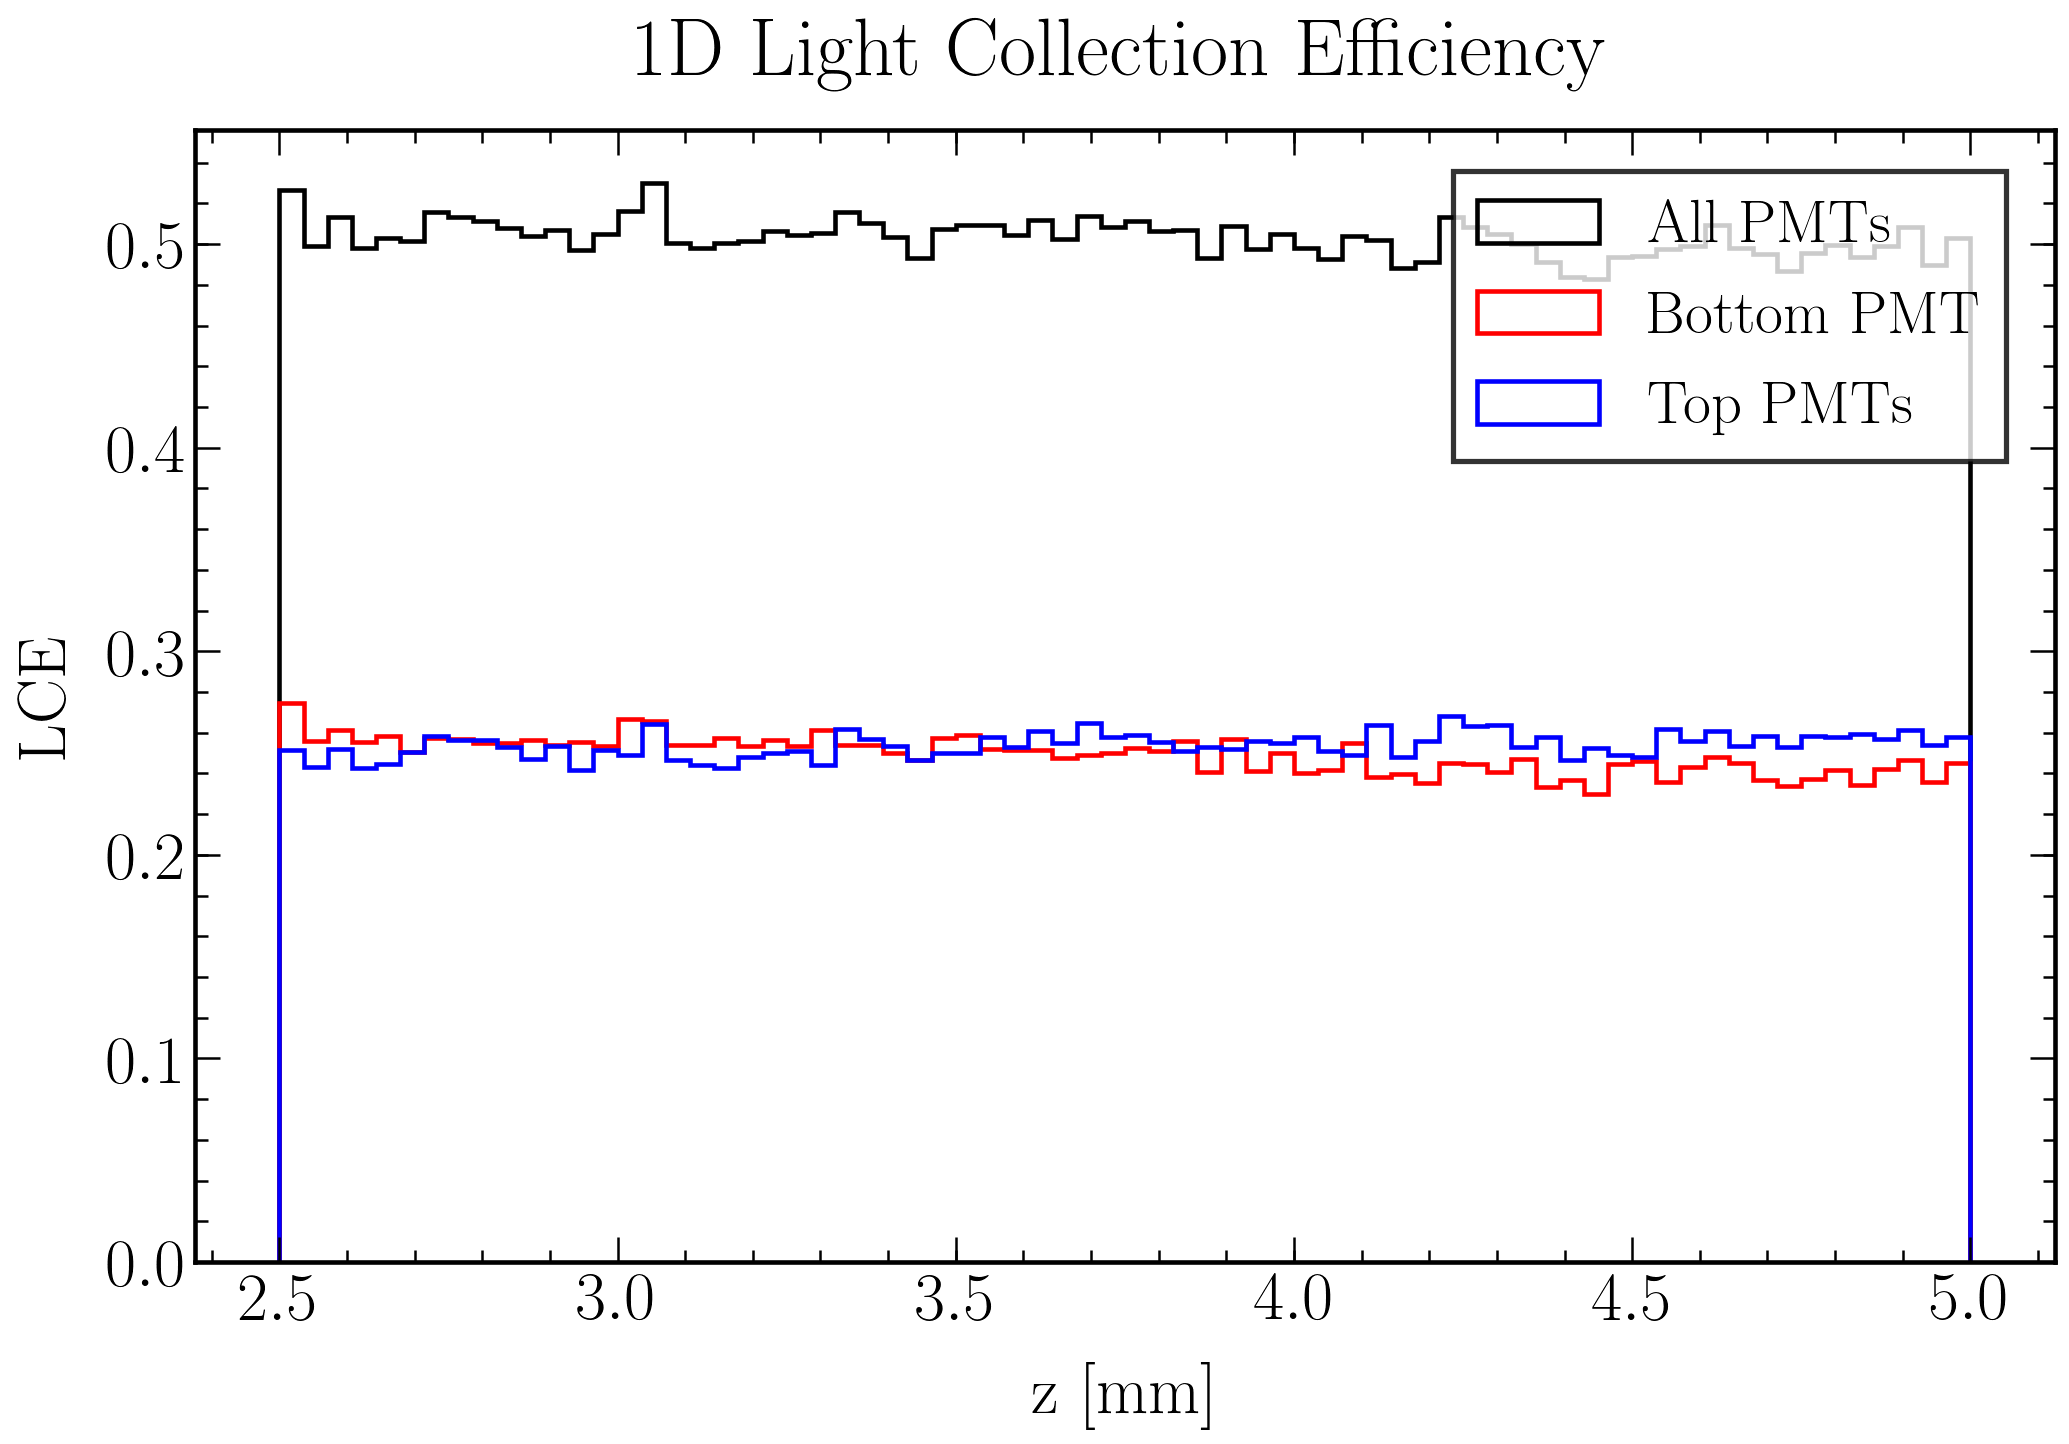

In [20]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = 70

'''n_zp_pri, bins_zp_pri = np.histogram(zp_pri, numberbins)
bins_center_zp_pri = (bins_zp_pri[:-1]+bins_zp_pri[1:])/2
plt.step(bins_center_zp_pri, n_zp_pri/(len(zp_pri)/numberbins),where='mid',color='k',linestyle='-')

n_nbpmthits, bins_nbpmthits = np.histogram(zp_pri, numberbins, weights = nbpmthits)
bins_center_nbpmthits = (bins_nbpmthits[:-1]+bins_nbpmthits[1:])/2
plt.step(bins_center_nbpmthits, n_nbpmthits/n_zp_pri,where='mid',color='k',linestyle='-')

n_ntpmthits, bins_ntpmthits = np.histogram(zp_pri, numberbins, weights = ntpmthits)
bins_center_ntpmthits = (bins_ntpmthits[:-1]+bins_ntpmthits[1:])/2
plt.step(bins_center_ntpmthits, n_ntpmthits/n_zp_pri,where='mid',color='k',linestyle='-')'''

# Data plot
#n, bins, patches = plt.hist(zp_pri, numberbins, weights = [1/(len(zp_pri)/numberbins)]*len(zp_pri), histtype = 'step', linewidth = 2.2, color = 'k')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.LCEwAll*numberbins, histtype = 'step', linewidth = 2.2, label = 'All PMTs', color = 'k')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.LCEwBottom*numberbins, histtype = 'step', linewidth = 2.2, label = 'Bottom PMT', color = 'r')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.LCEwTop*numberbins, histtype = 'step', linewidth = 2.2, label = 'Top PMTs', color = 'b')

plt.xlabel('z [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.title('1D Light Collection Efficiency', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(-10,180)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_z_comparison.png")
plt.show()

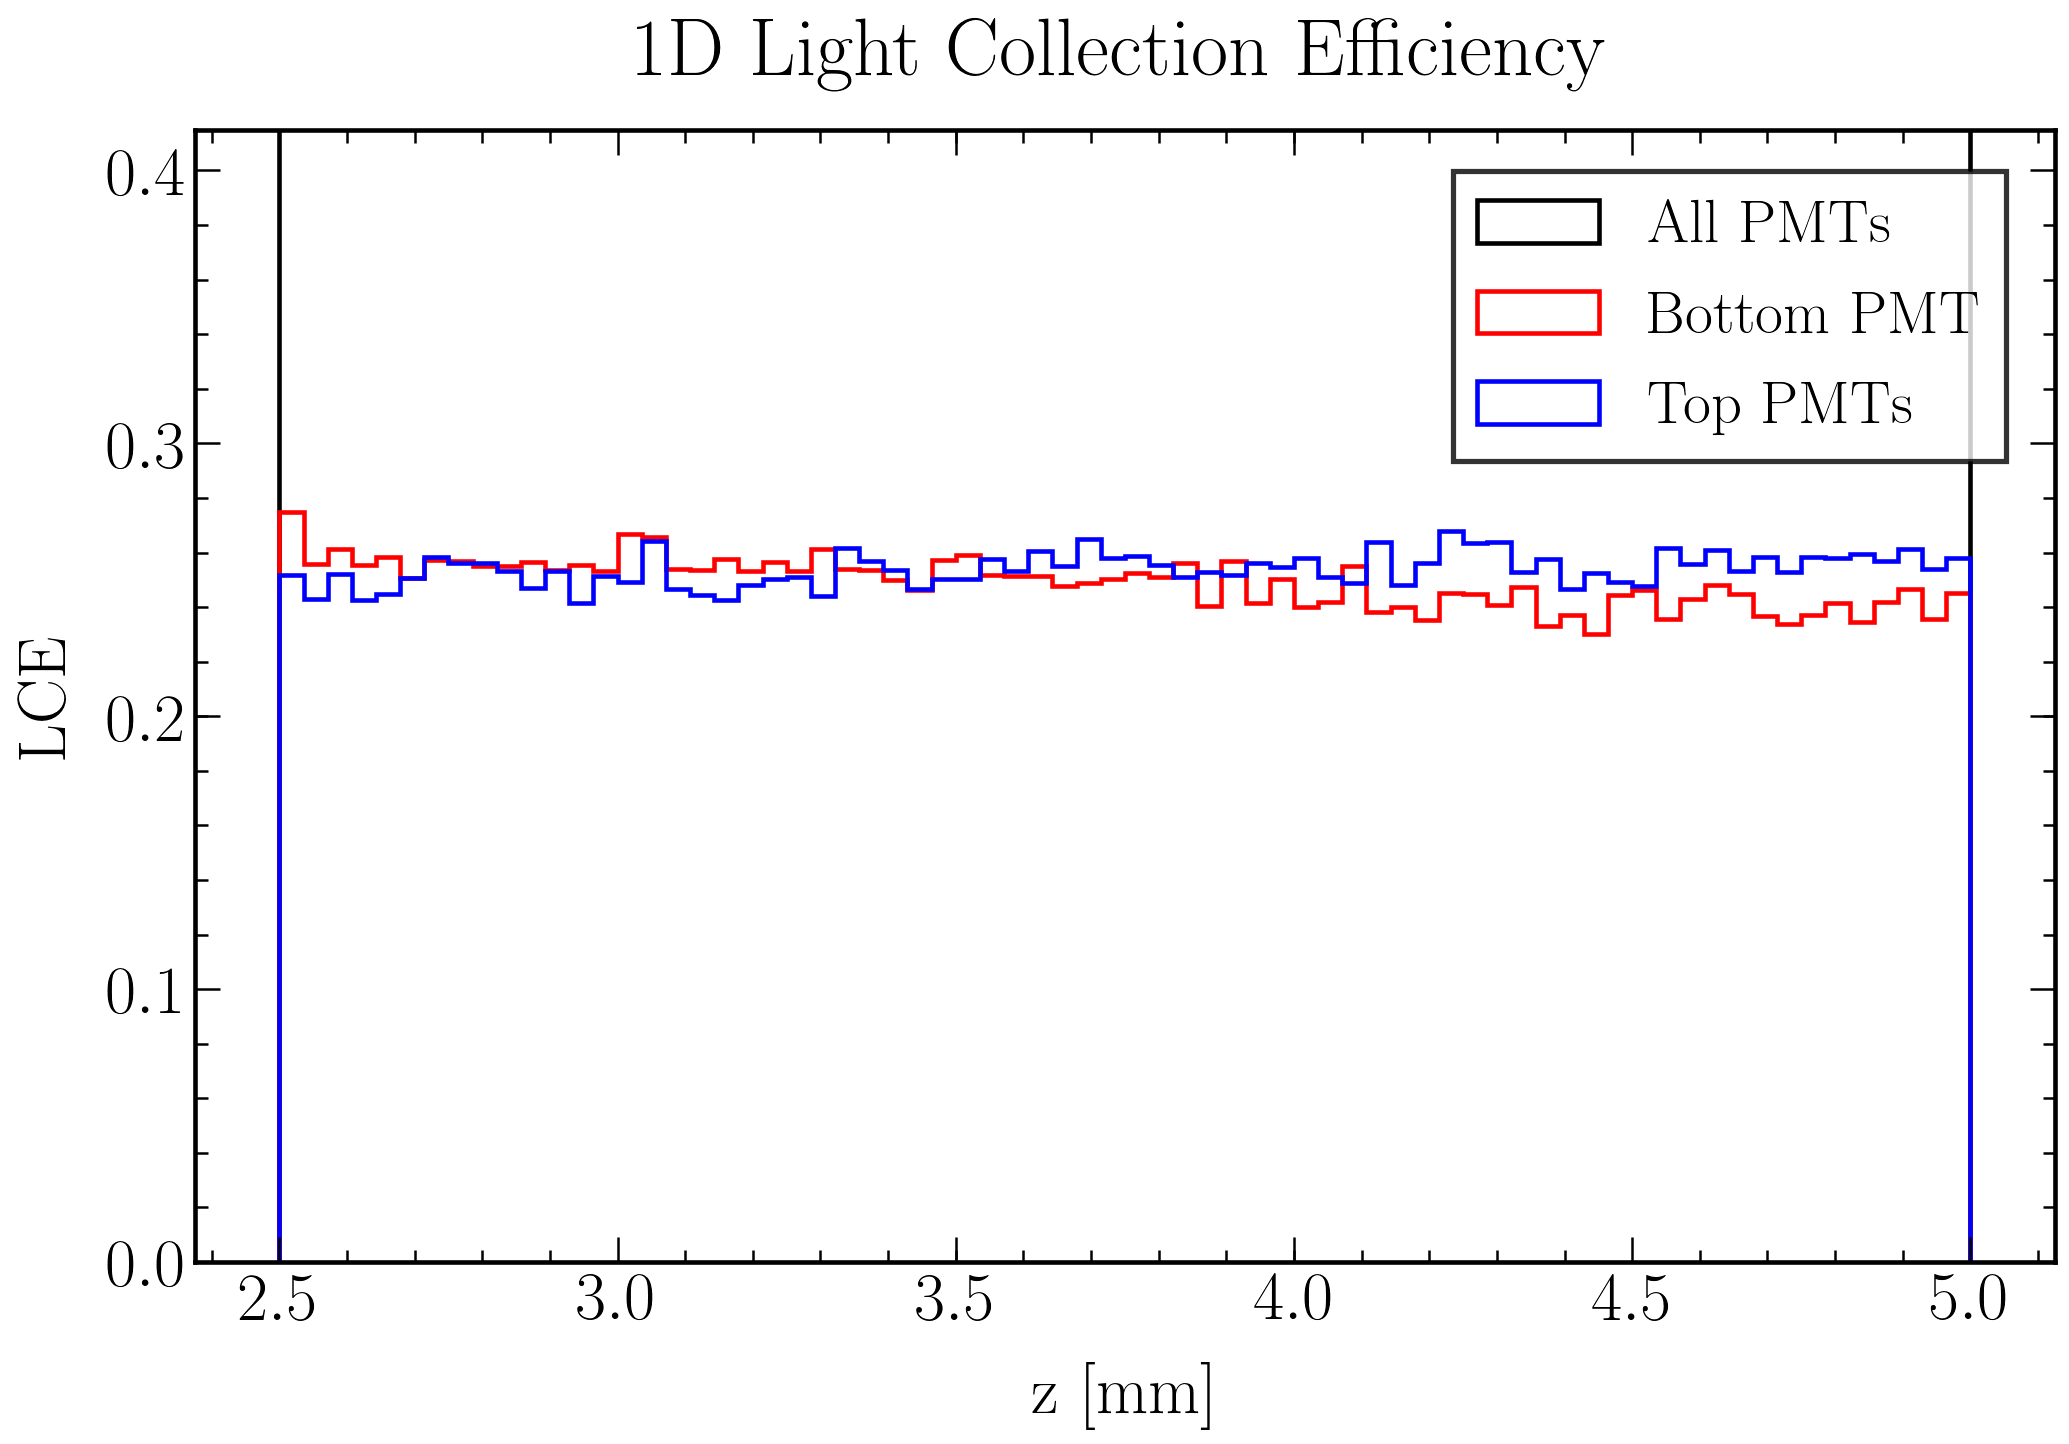

In [21]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = 70

# Data plot
#n, bins, patches = plt.hist(zp_pri, numberbins, weights = [1/(len(zp_pri)/numberbins)]*len(zp_pri), histtype = 'step', linewidth = 2.2, color = 'k')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.LCEwAll*numberbins, histtype = 'step', linewidth = 2.2, label = 'All PMTs', color = 'k')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.LCEwBottom*numberbins, histtype = 'step', linewidth = 2.2, label = 'Bottom PMT', color = 'r')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.LCEwTop*numberbins, histtype = 'step', linewidth = 2.2, label = 'Top PMTs', color = 'b')

plt.xlabel('z [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.title('1D Light Collection Efficiency', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
plt.ylim(0.,0.415)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_z_comparison_scaled.png")
plt.show()

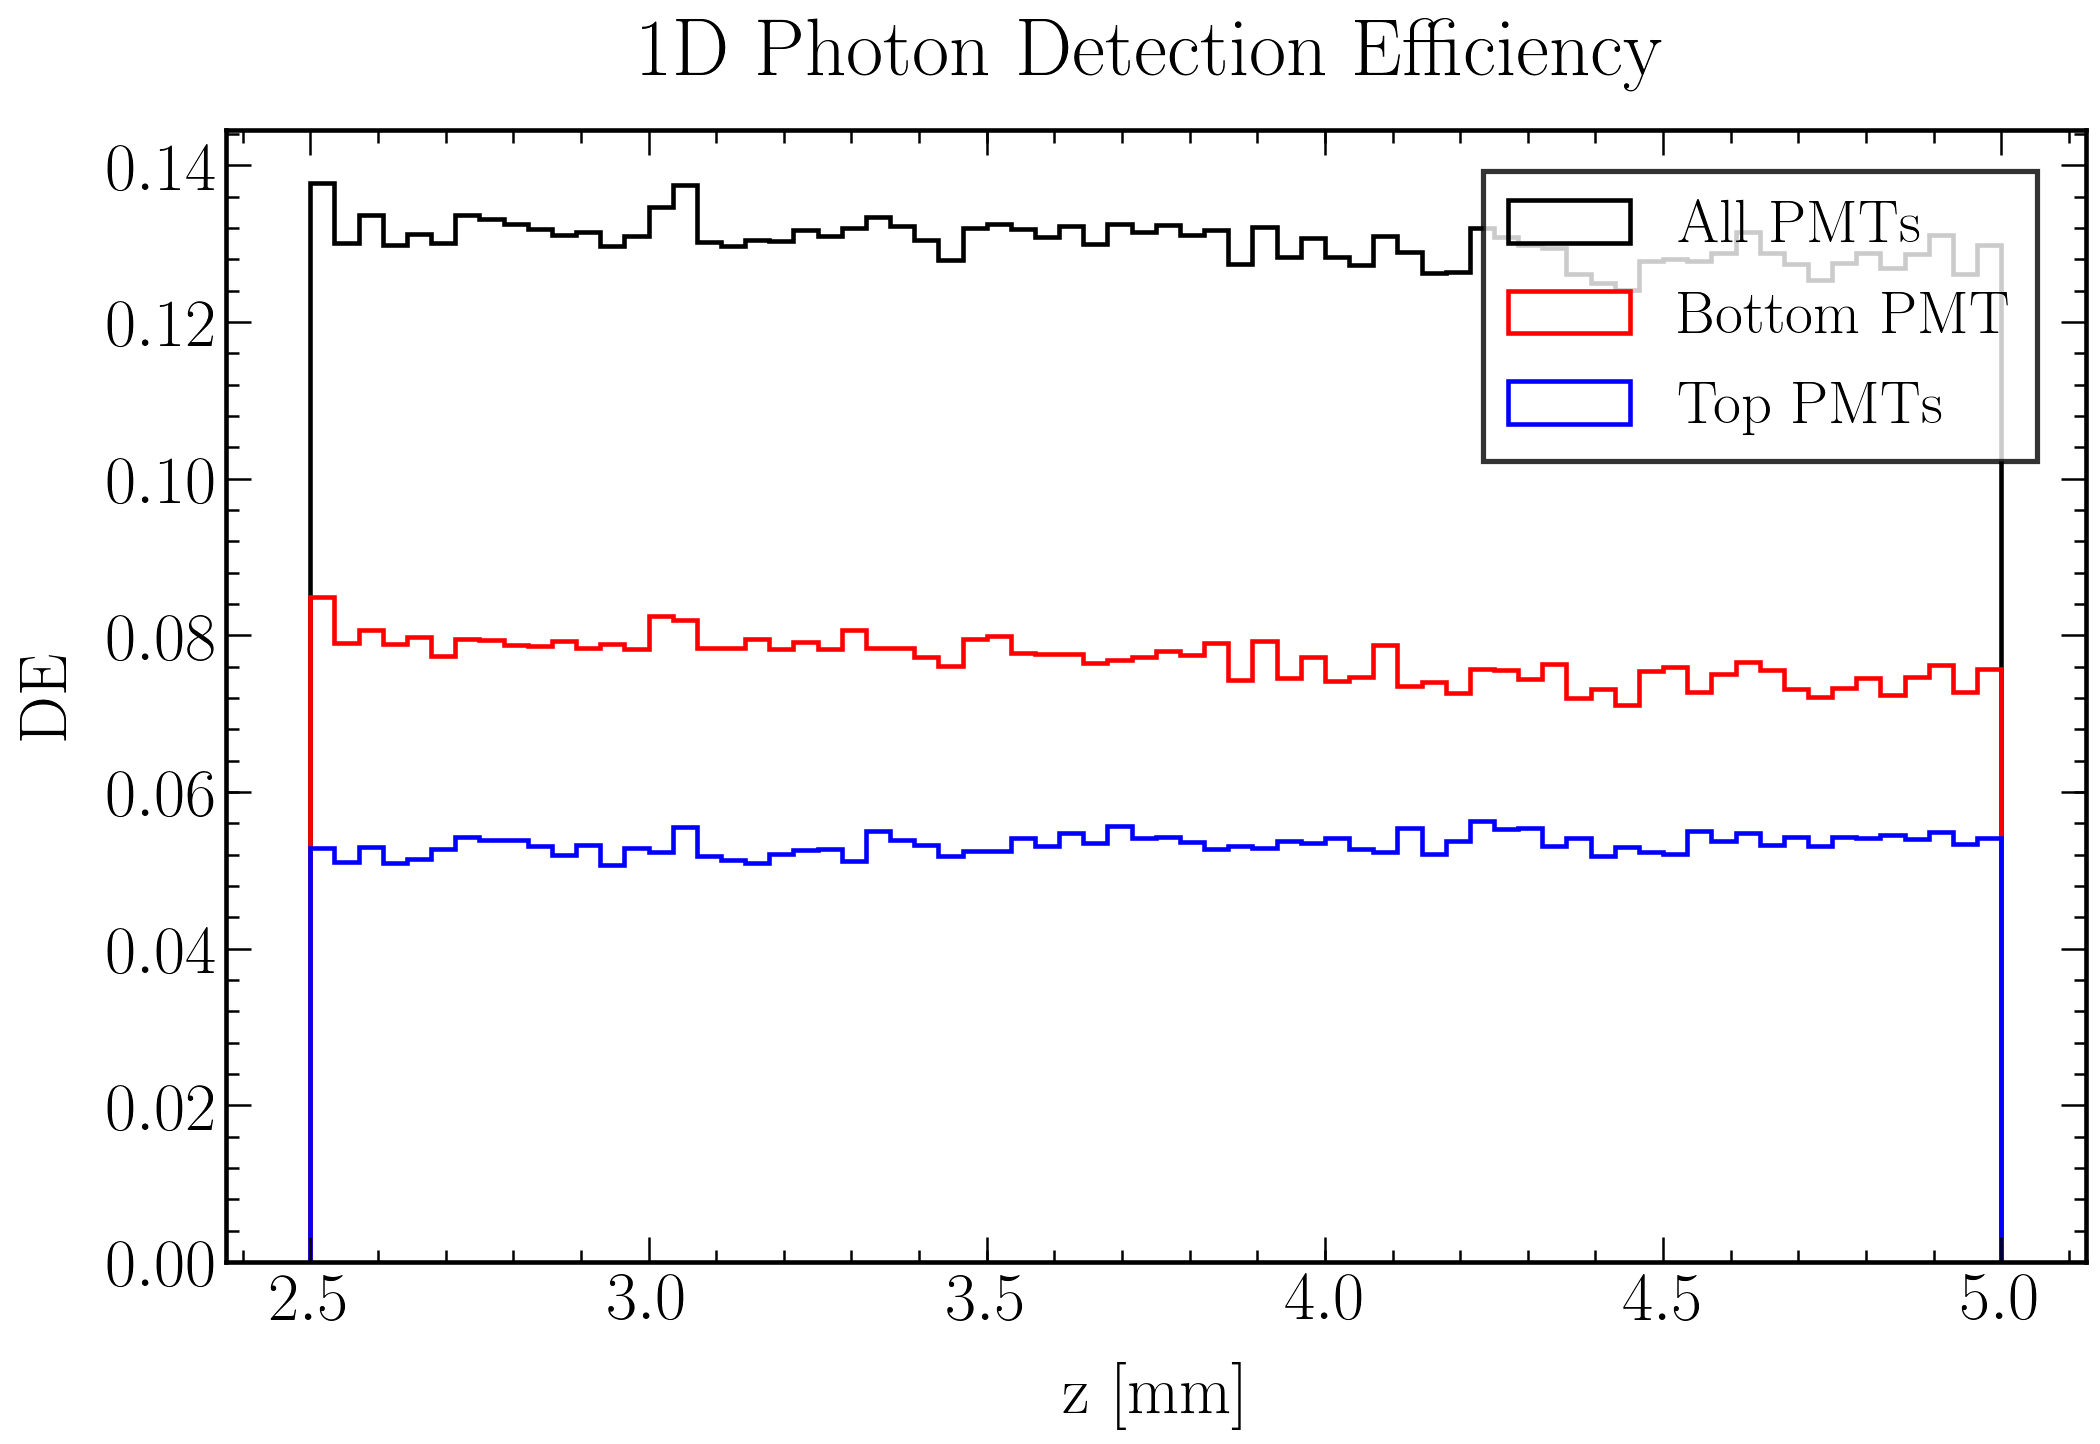

In [22]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = 70

# Data plot
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.DEwAll*numberbins, histtype = 'step', linewidth = 2.2, label = 'All PMTs', color = 'k')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.DEwBottom*numberbins, histtype = 'step', linewidth = 2.2, label = 'Bottom PMT', color = 'r')
n, bins, patches = plt.hist(_chunk_collect.zp_pri, numberbins, weights = _chunk_collect.DEwTop*numberbins, histtype = 'step', linewidth = 2.2, label = 'Top PMTs', color = 'b')

plt.xlabel('z [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('DE', fontsize = label_size, labelpad = label_pad)
plt.title('1D Photon Detection Efficiency', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(-10,180)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_DE_z_comparison.png")
plt.show()

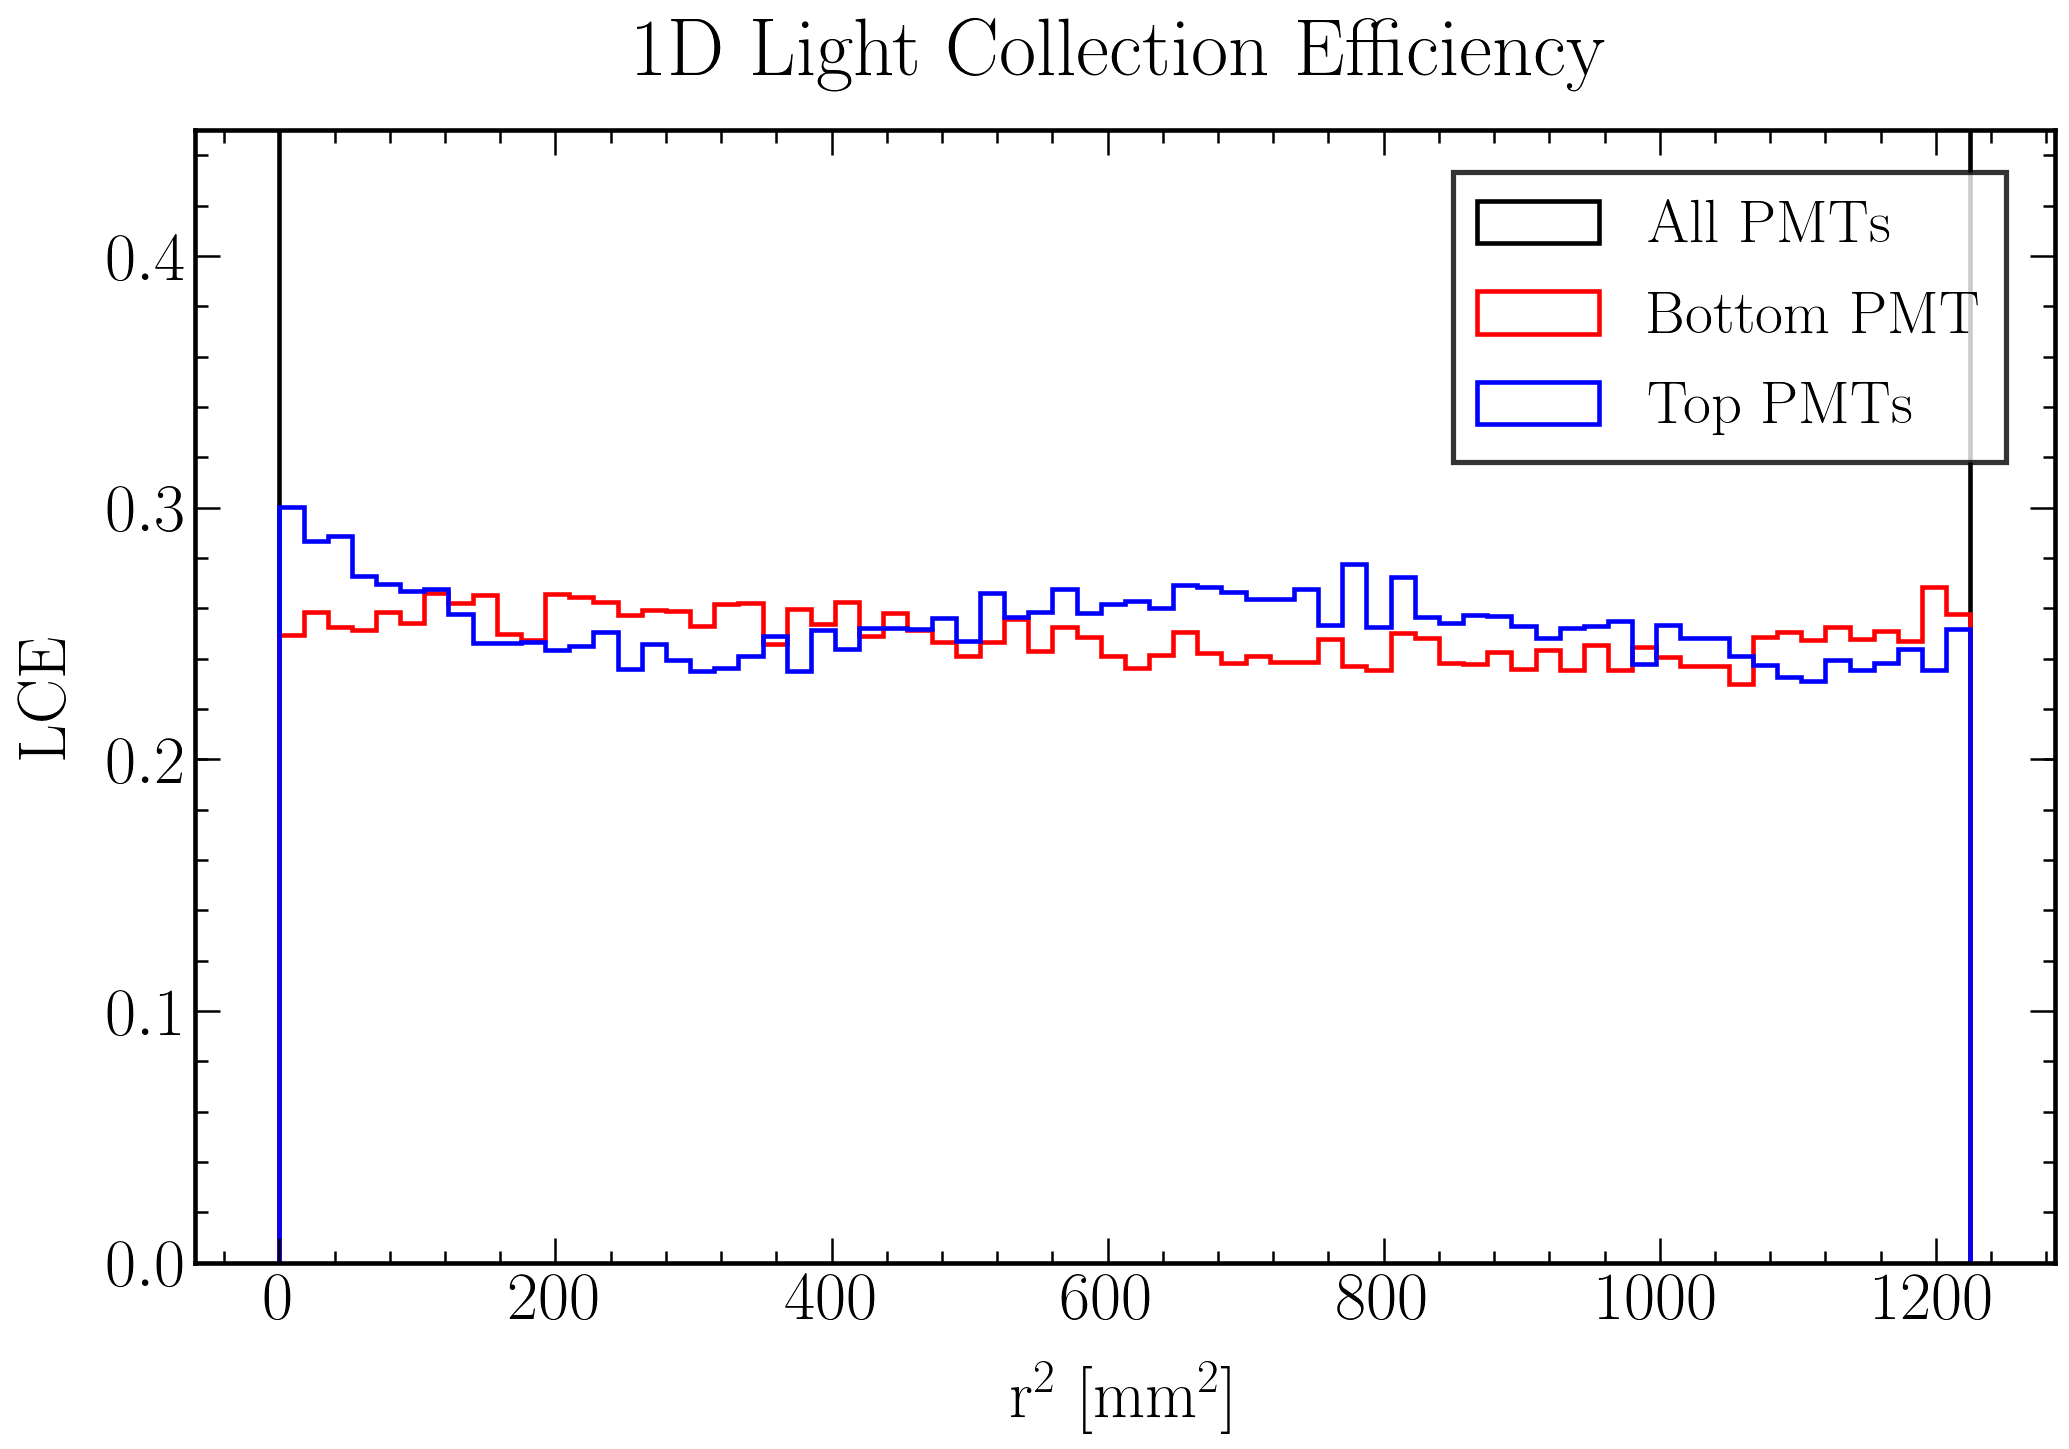

In [23]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = 70

# Data plot
n, bins, patches = plt.hist(_chunk_collect.rp_pri2, numberbins, weights = _chunk_collect.LCEwAll*numberbins, histtype = 'step', linewidth = 2.2, label = 'All PMTs', color = 'k')
n, bins, patches = plt.hist(_chunk_collect.rp_pri2, numberbins, weights = _chunk_collect.LCEwBottom*numberbins, histtype = 'step', linewidth = 2.2, label = 'Bottom PMT', color = 'r')
n, bins, patches = plt.hist(_chunk_collect.rp_pri2, numberbins, weights = _chunk_collect.LCEwTop*numberbins, histtype = 'step', linewidth = 2.2, label = 'Top PMTs', color = 'b')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('LCE', fontsize = label_size, labelpad = label_pad)
plt.title('1D Light Collection Efficiency', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

# Axes ---> Range
#plt.xlim(0,100)
plt.ylim(0,0.45)
#plt.ylim(0,0.12)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_comparison.png")
plt.show()

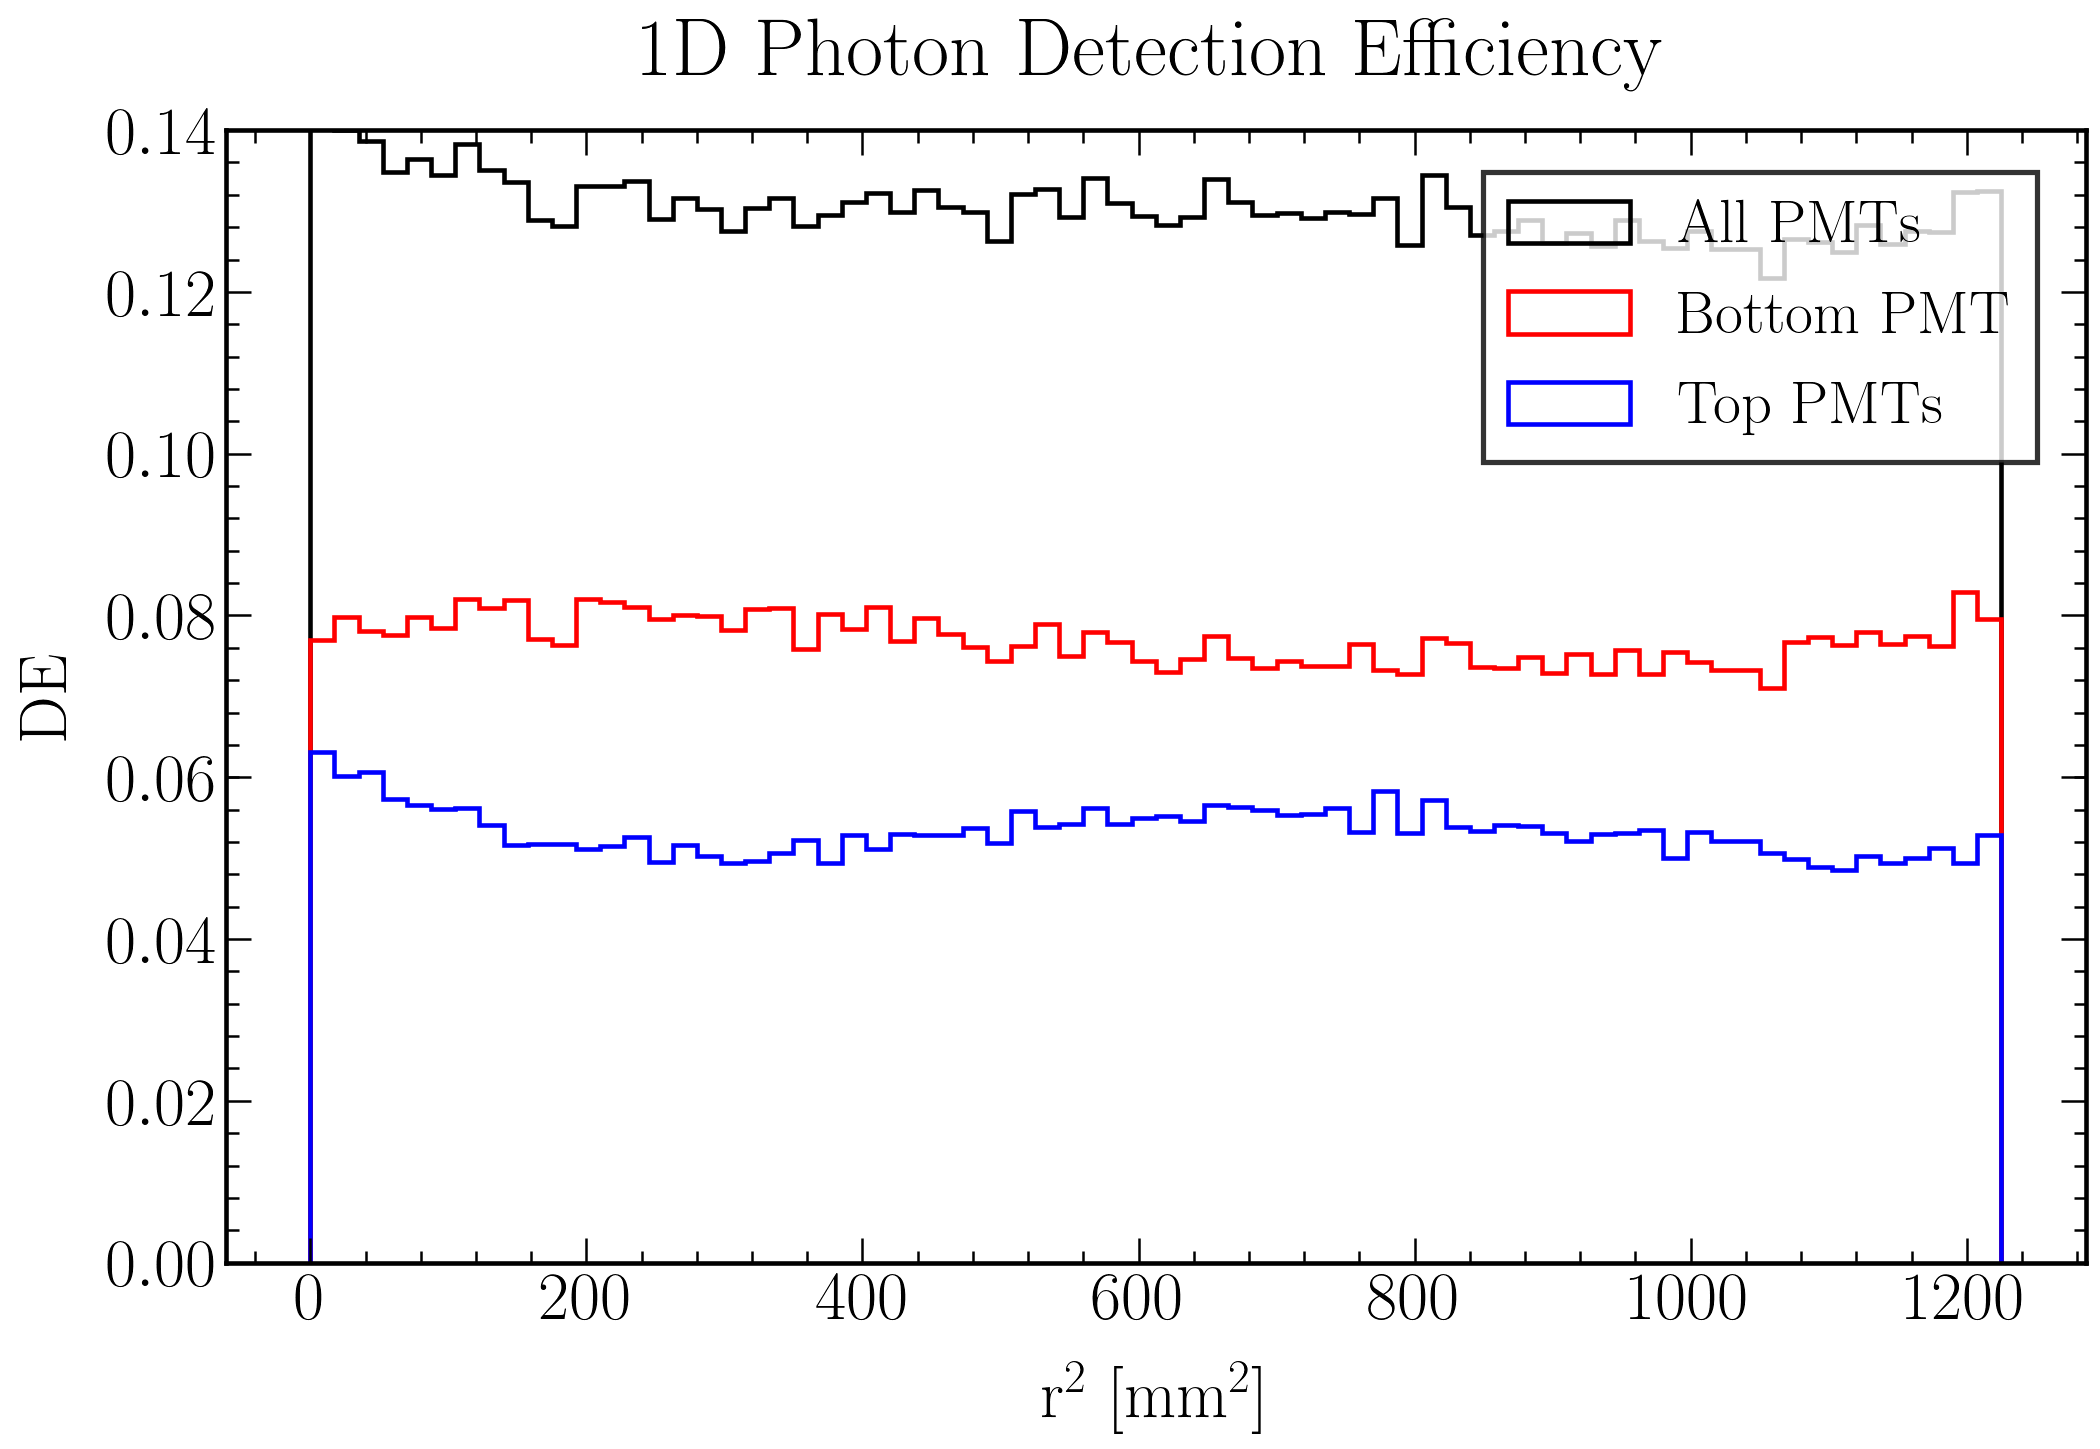

In [24]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = 70

# Data plot
n, bins, patches = plt.hist(_chunk_collect.rp_pri2, numberbins, weights = _chunk_collect.DEwAll*numberbins, histtype = 'step', linewidth = 2.2, label = 'All PMTs', color = 'k')
n, bins, patches = plt.hist(_chunk_collect.rp_pri2, numberbins, weights = _chunk_collect.DEwBottom*numberbins, histtype = 'step', linewidth = 2.2, label = 'Bottom PMT', color = 'r')
n, bins, patches = plt.hist(_chunk_collect.rp_pri2, numberbins, weights = _chunk_collect.DEwTop*numberbins, histtype = 'step', linewidth = 2.2, label = 'Top PMTs', color = 'b')

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('DE', fontsize = label_size, labelpad = label_pad)
plt.title('1D Photon Detection Efficiency', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

# Axes ---> Range
#plt.xlim(0,100)
#plt.ylim(0,0.42)
plt.ylim(0,0.14)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_DE_r2_comparison.png")
plt.show()

### 2D Light Collection Efficiency

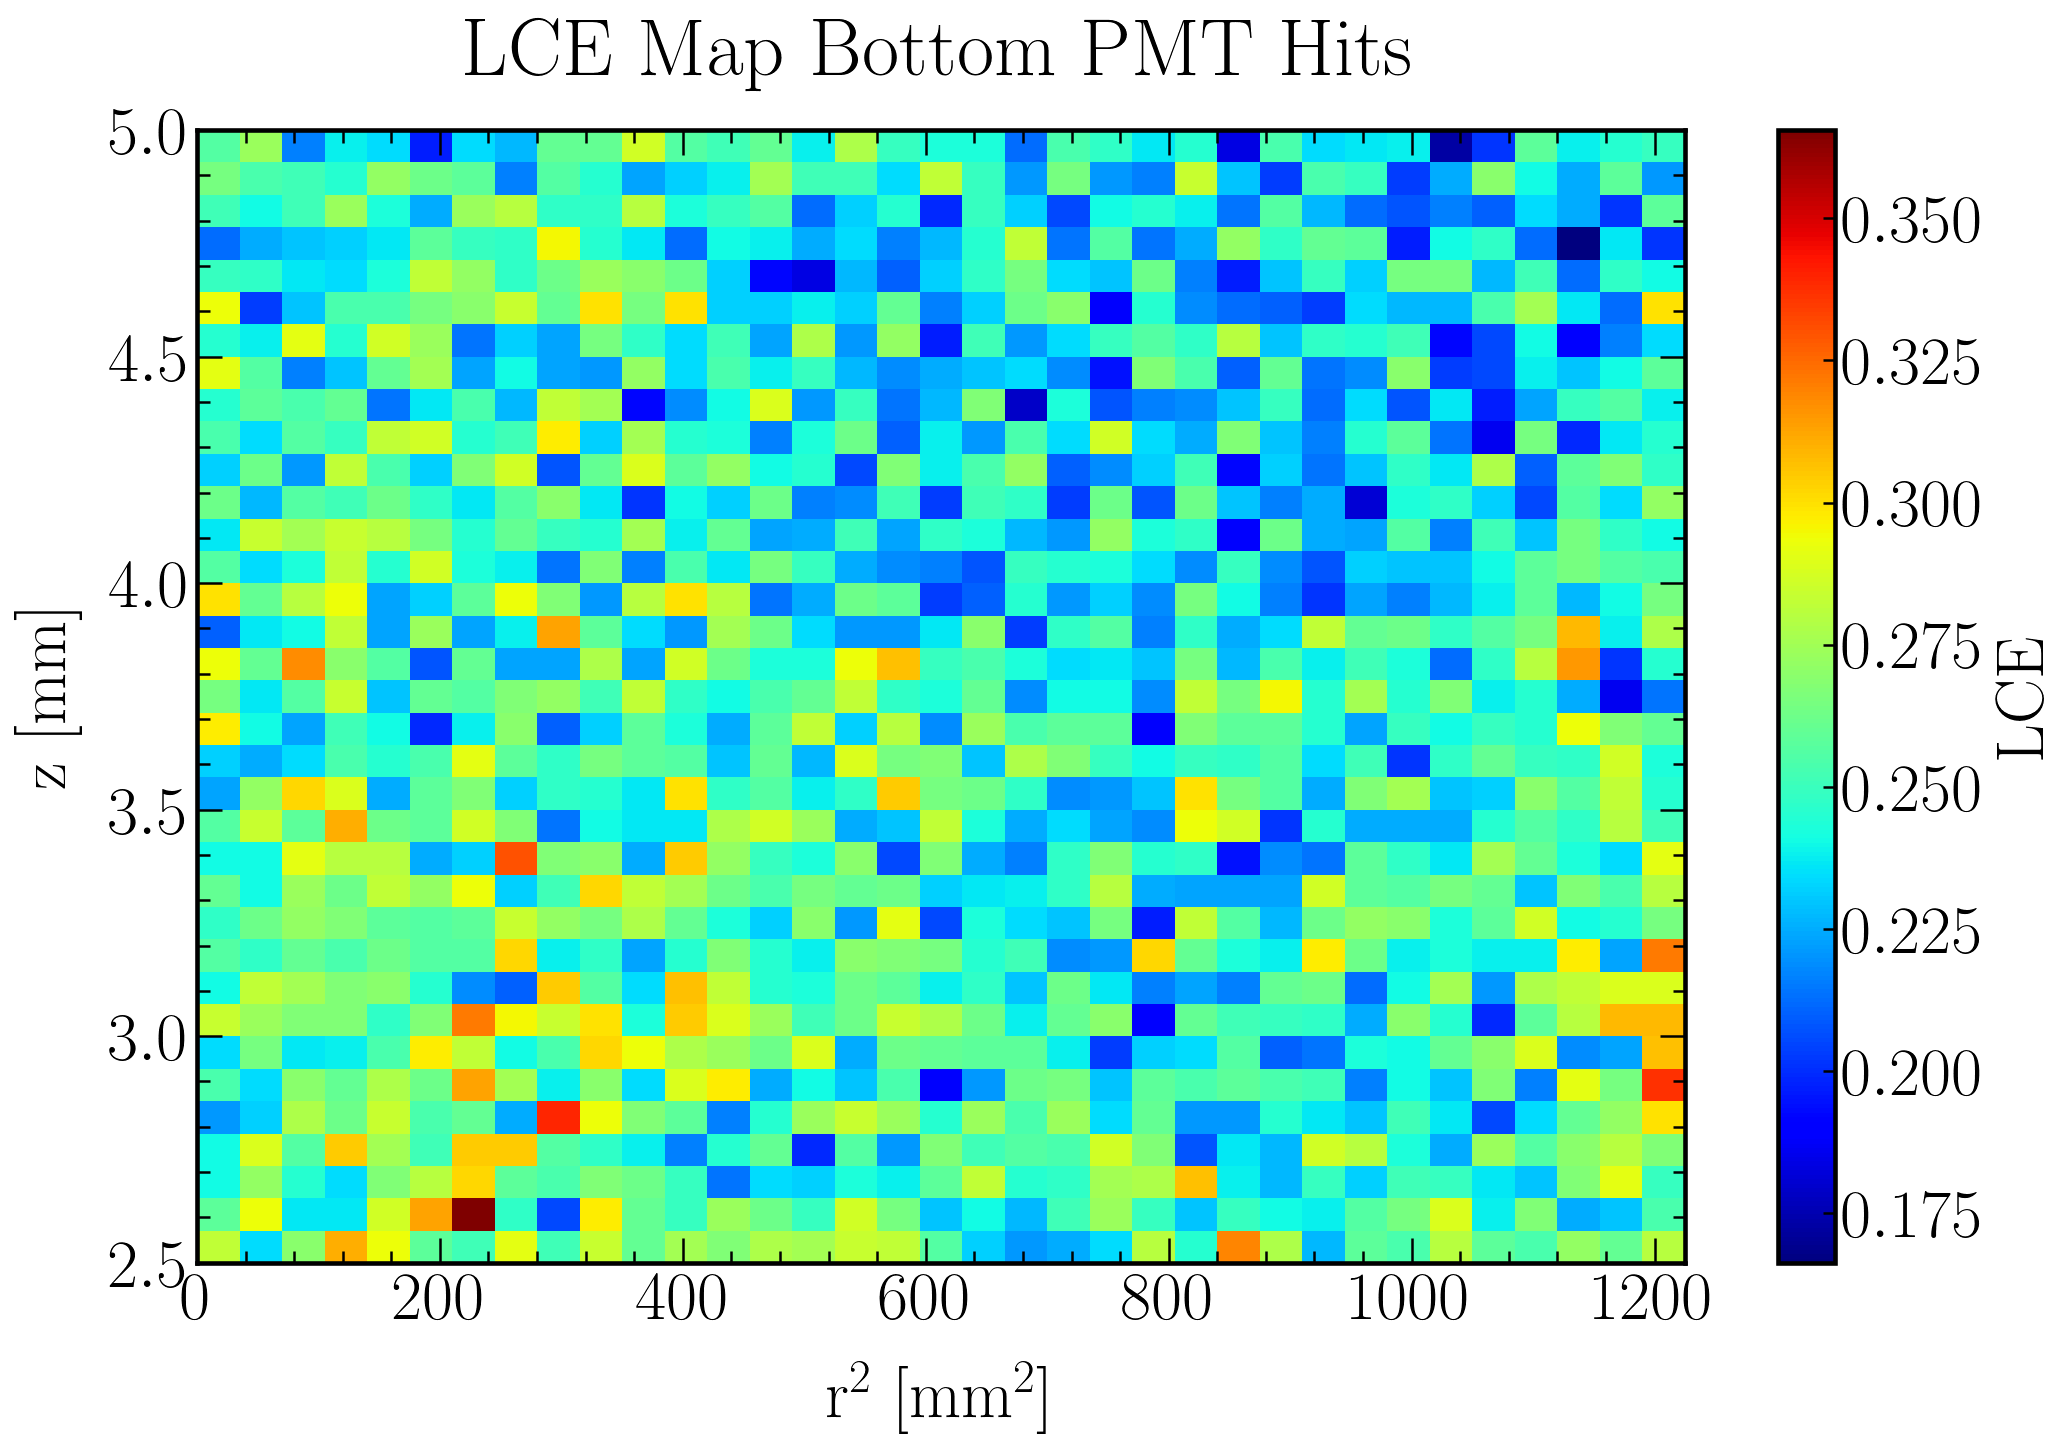

In [25]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = 35

# Data plot
plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LCEwBottom*(numberbins*numberbins), cmap = 'jet')#, normed = True, norm=LogNorm()

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Bottom PMT Hits', fontsize = title_size, pad = title_pad)

#plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Bottom.png")
plt.show()

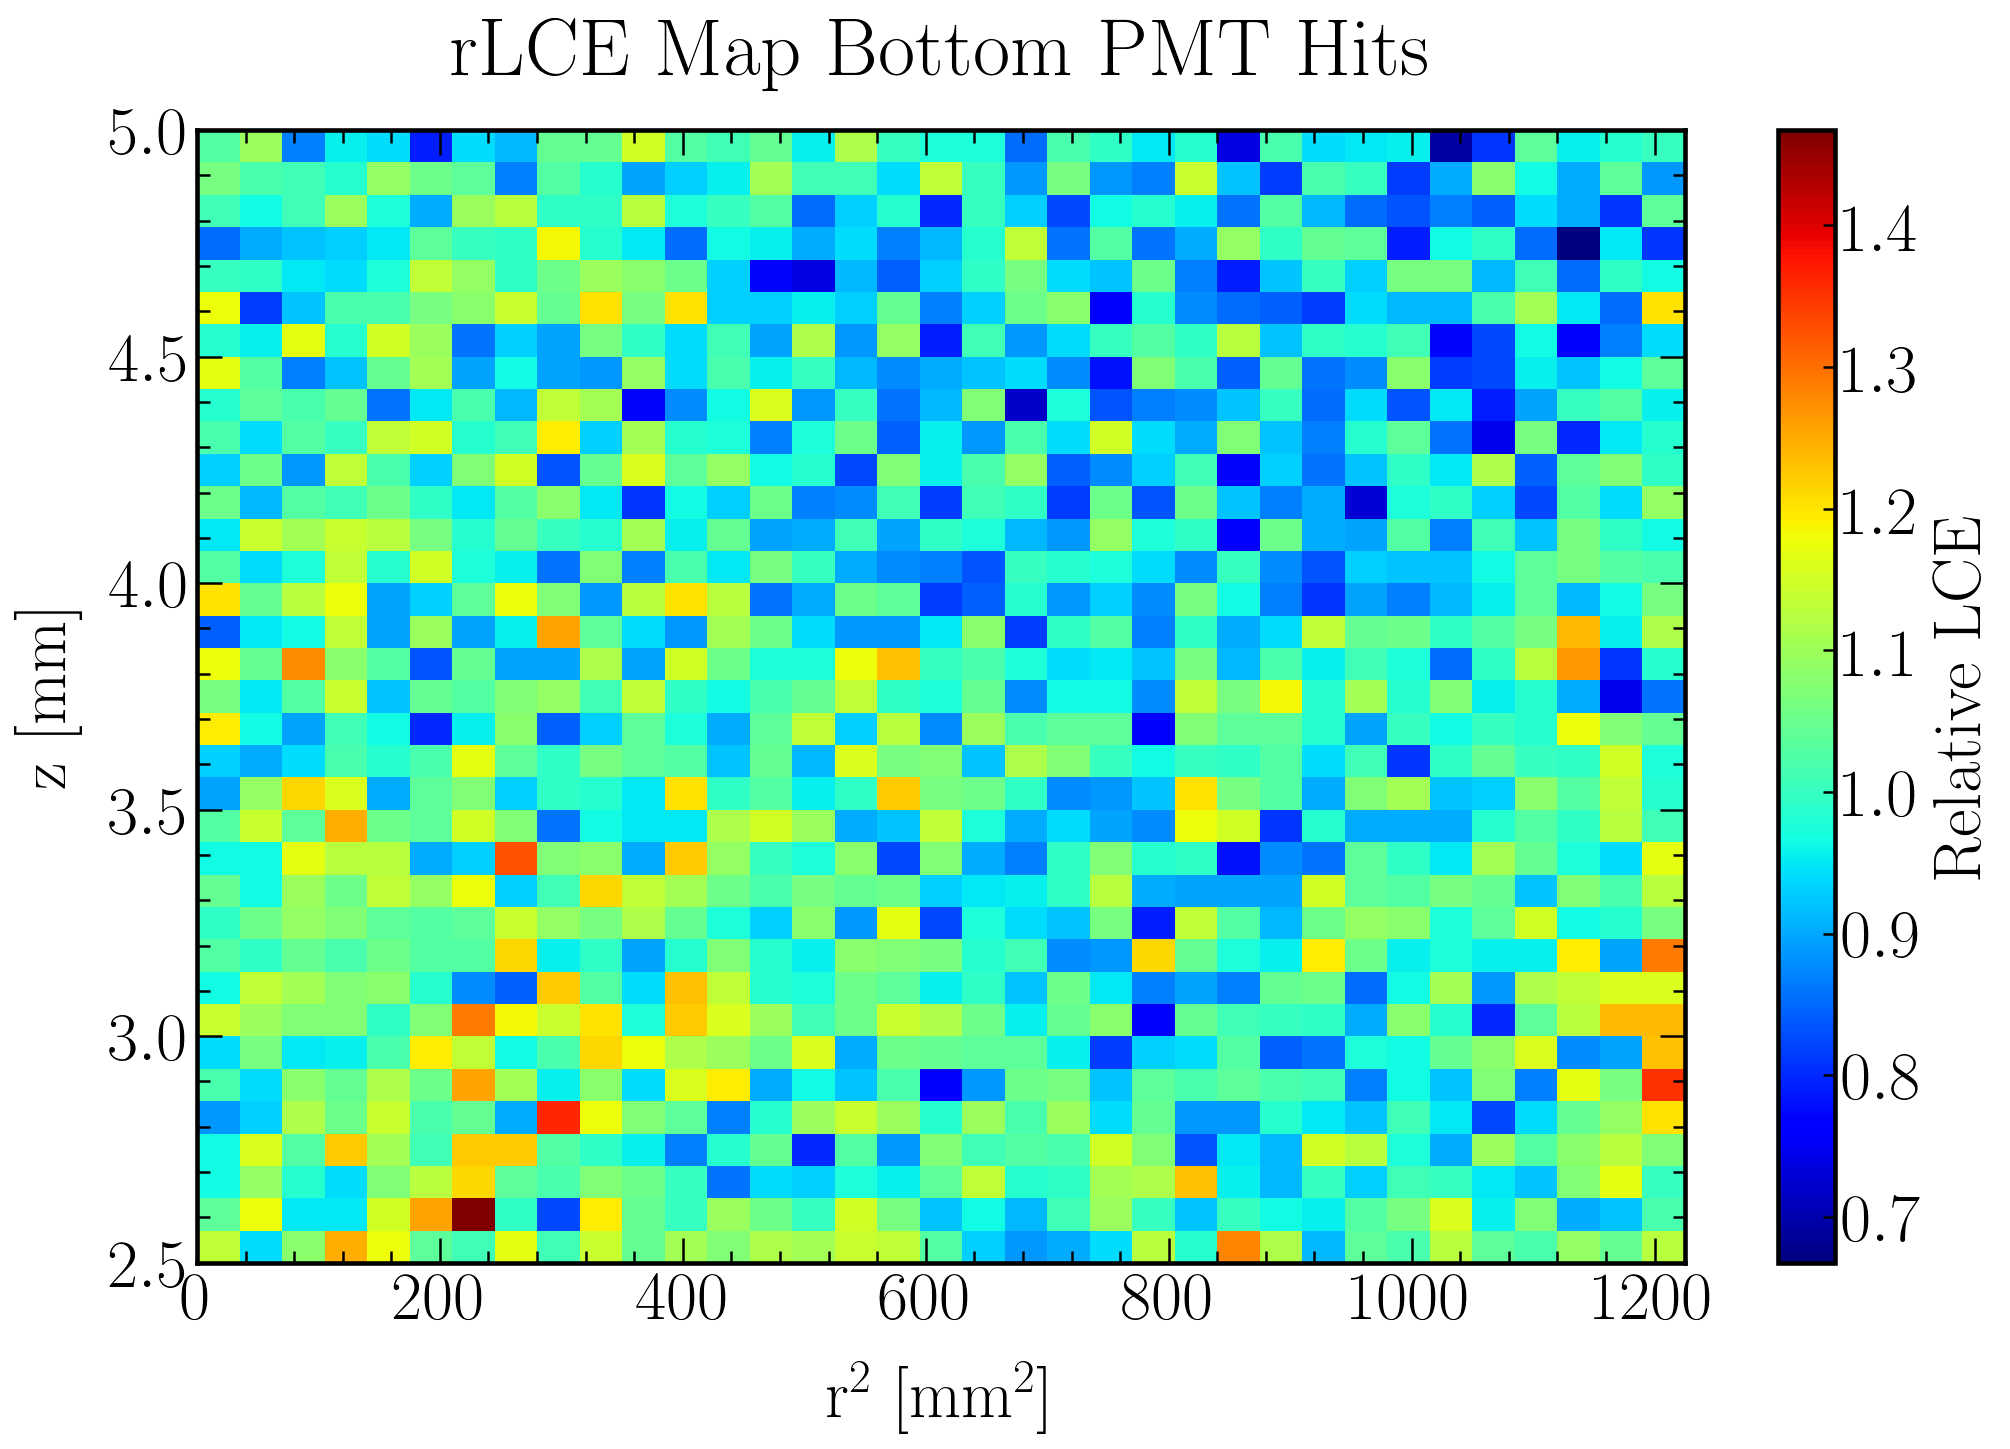

In [26]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = 35

# Data plot
plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.nbpmthits/(nbpmthits_sum/(numberbins*numberbins)), cmap = 'jet')#, normed = True, norm=LogNorm()

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('rLCE Map Bottom PMT Hits', fontsize = title_size, pad = title_pad)

#plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Relative LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Bottom_rel.png")
plt.show()

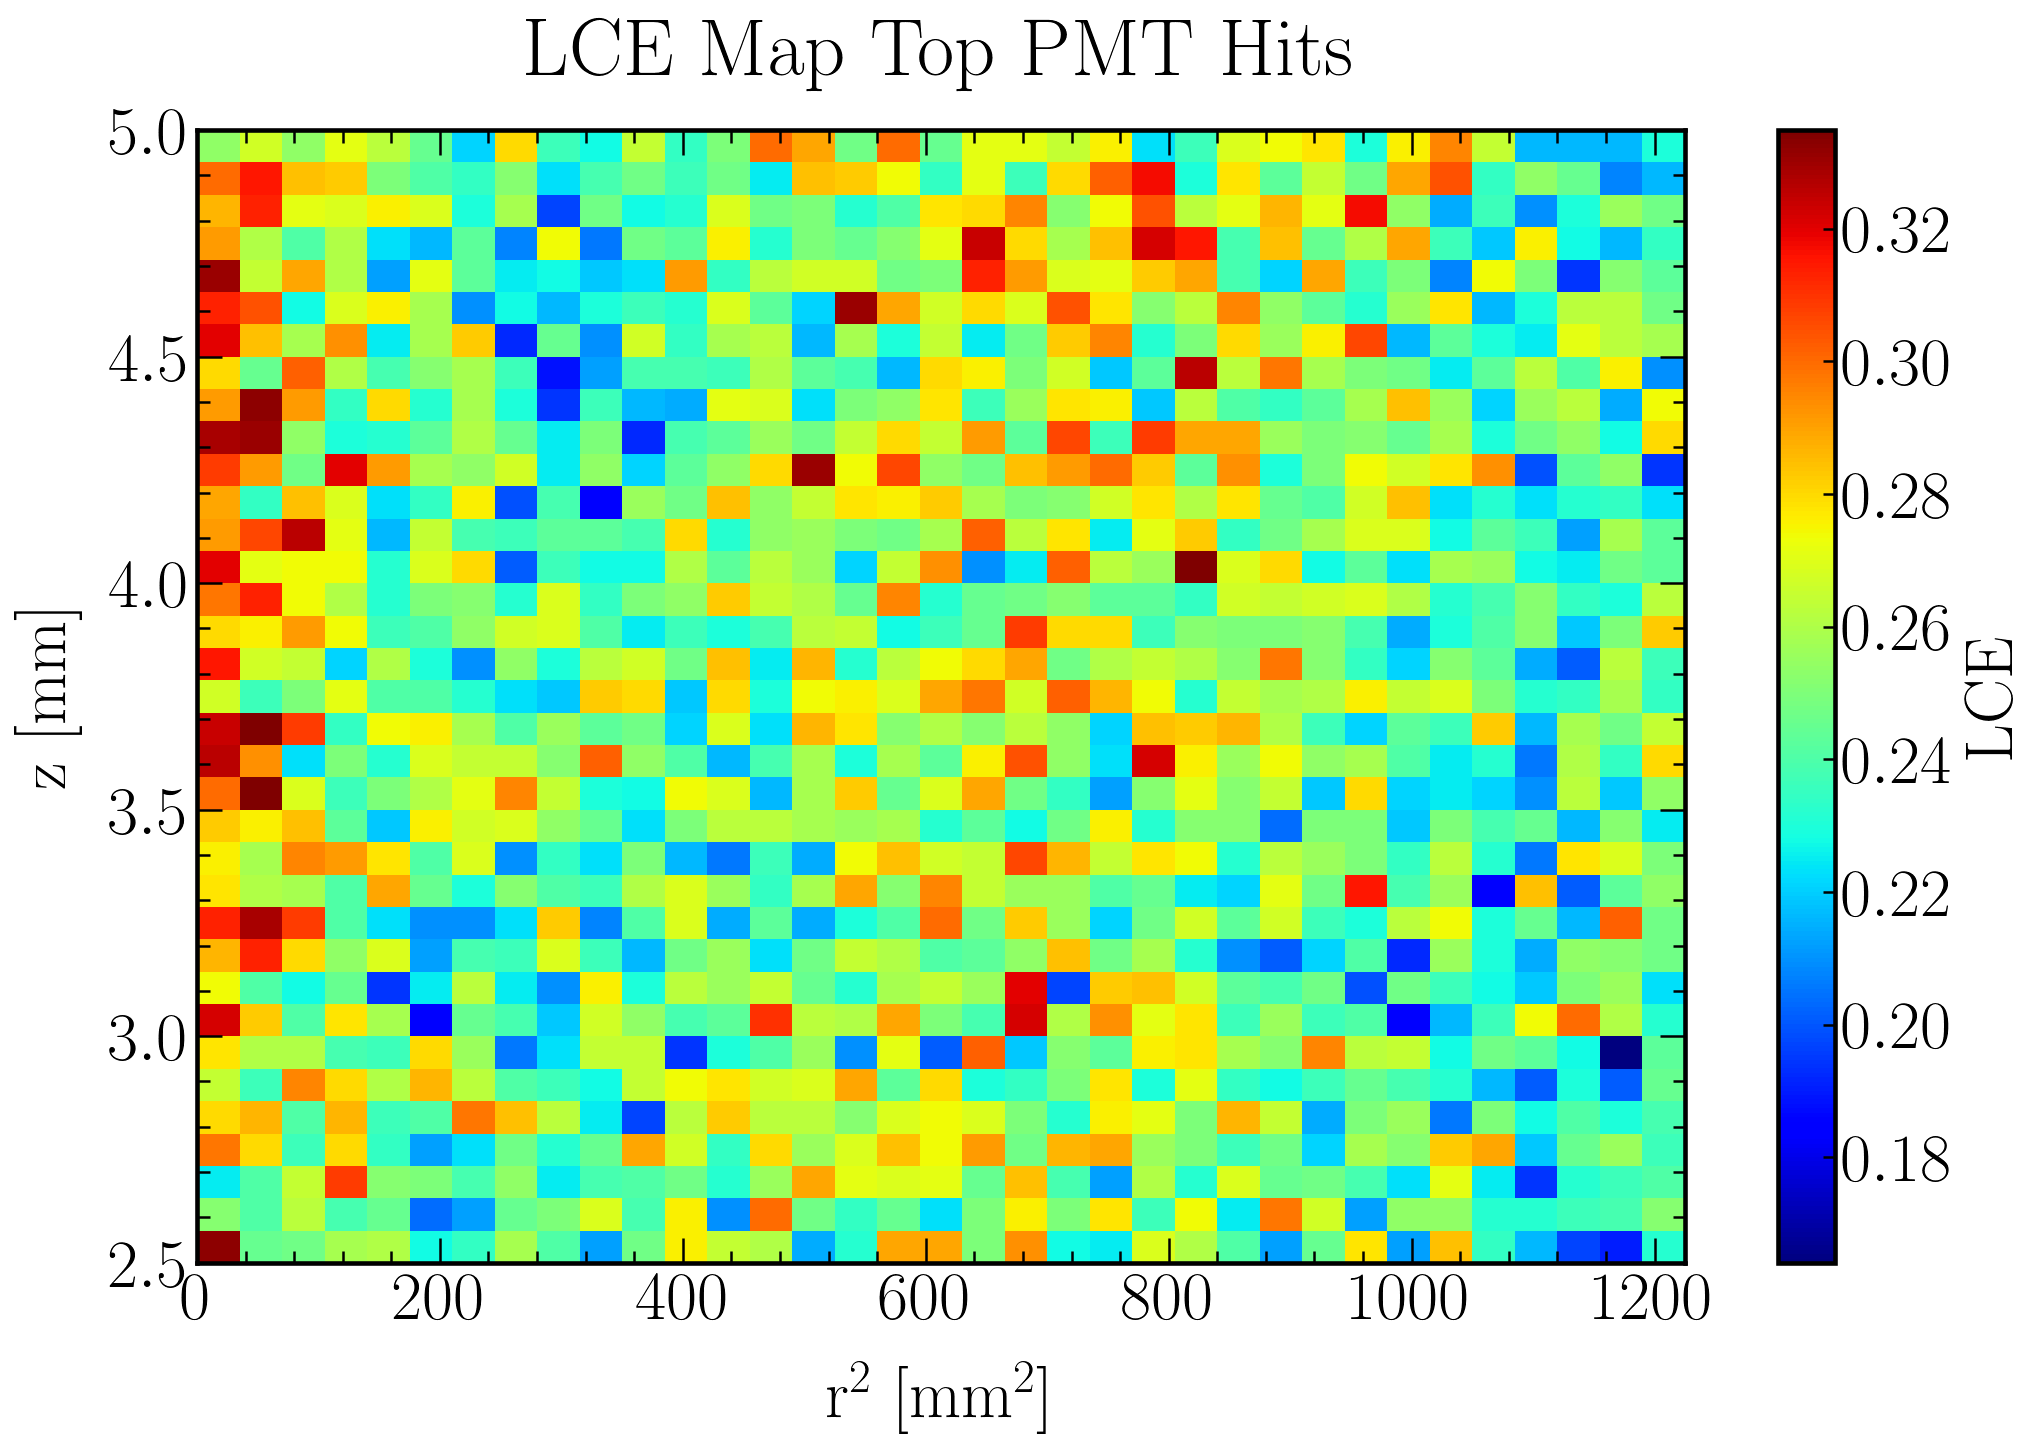

In [27]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = 35

# Data plot
plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LCEwTop*(numberbins*numberbins), cmap = 'jet')#, normed = True, norm=LogNorm()

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Top PMT Hits', fontsize = title_size, pad = title_pad)

#plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Top.png")
plt.show()

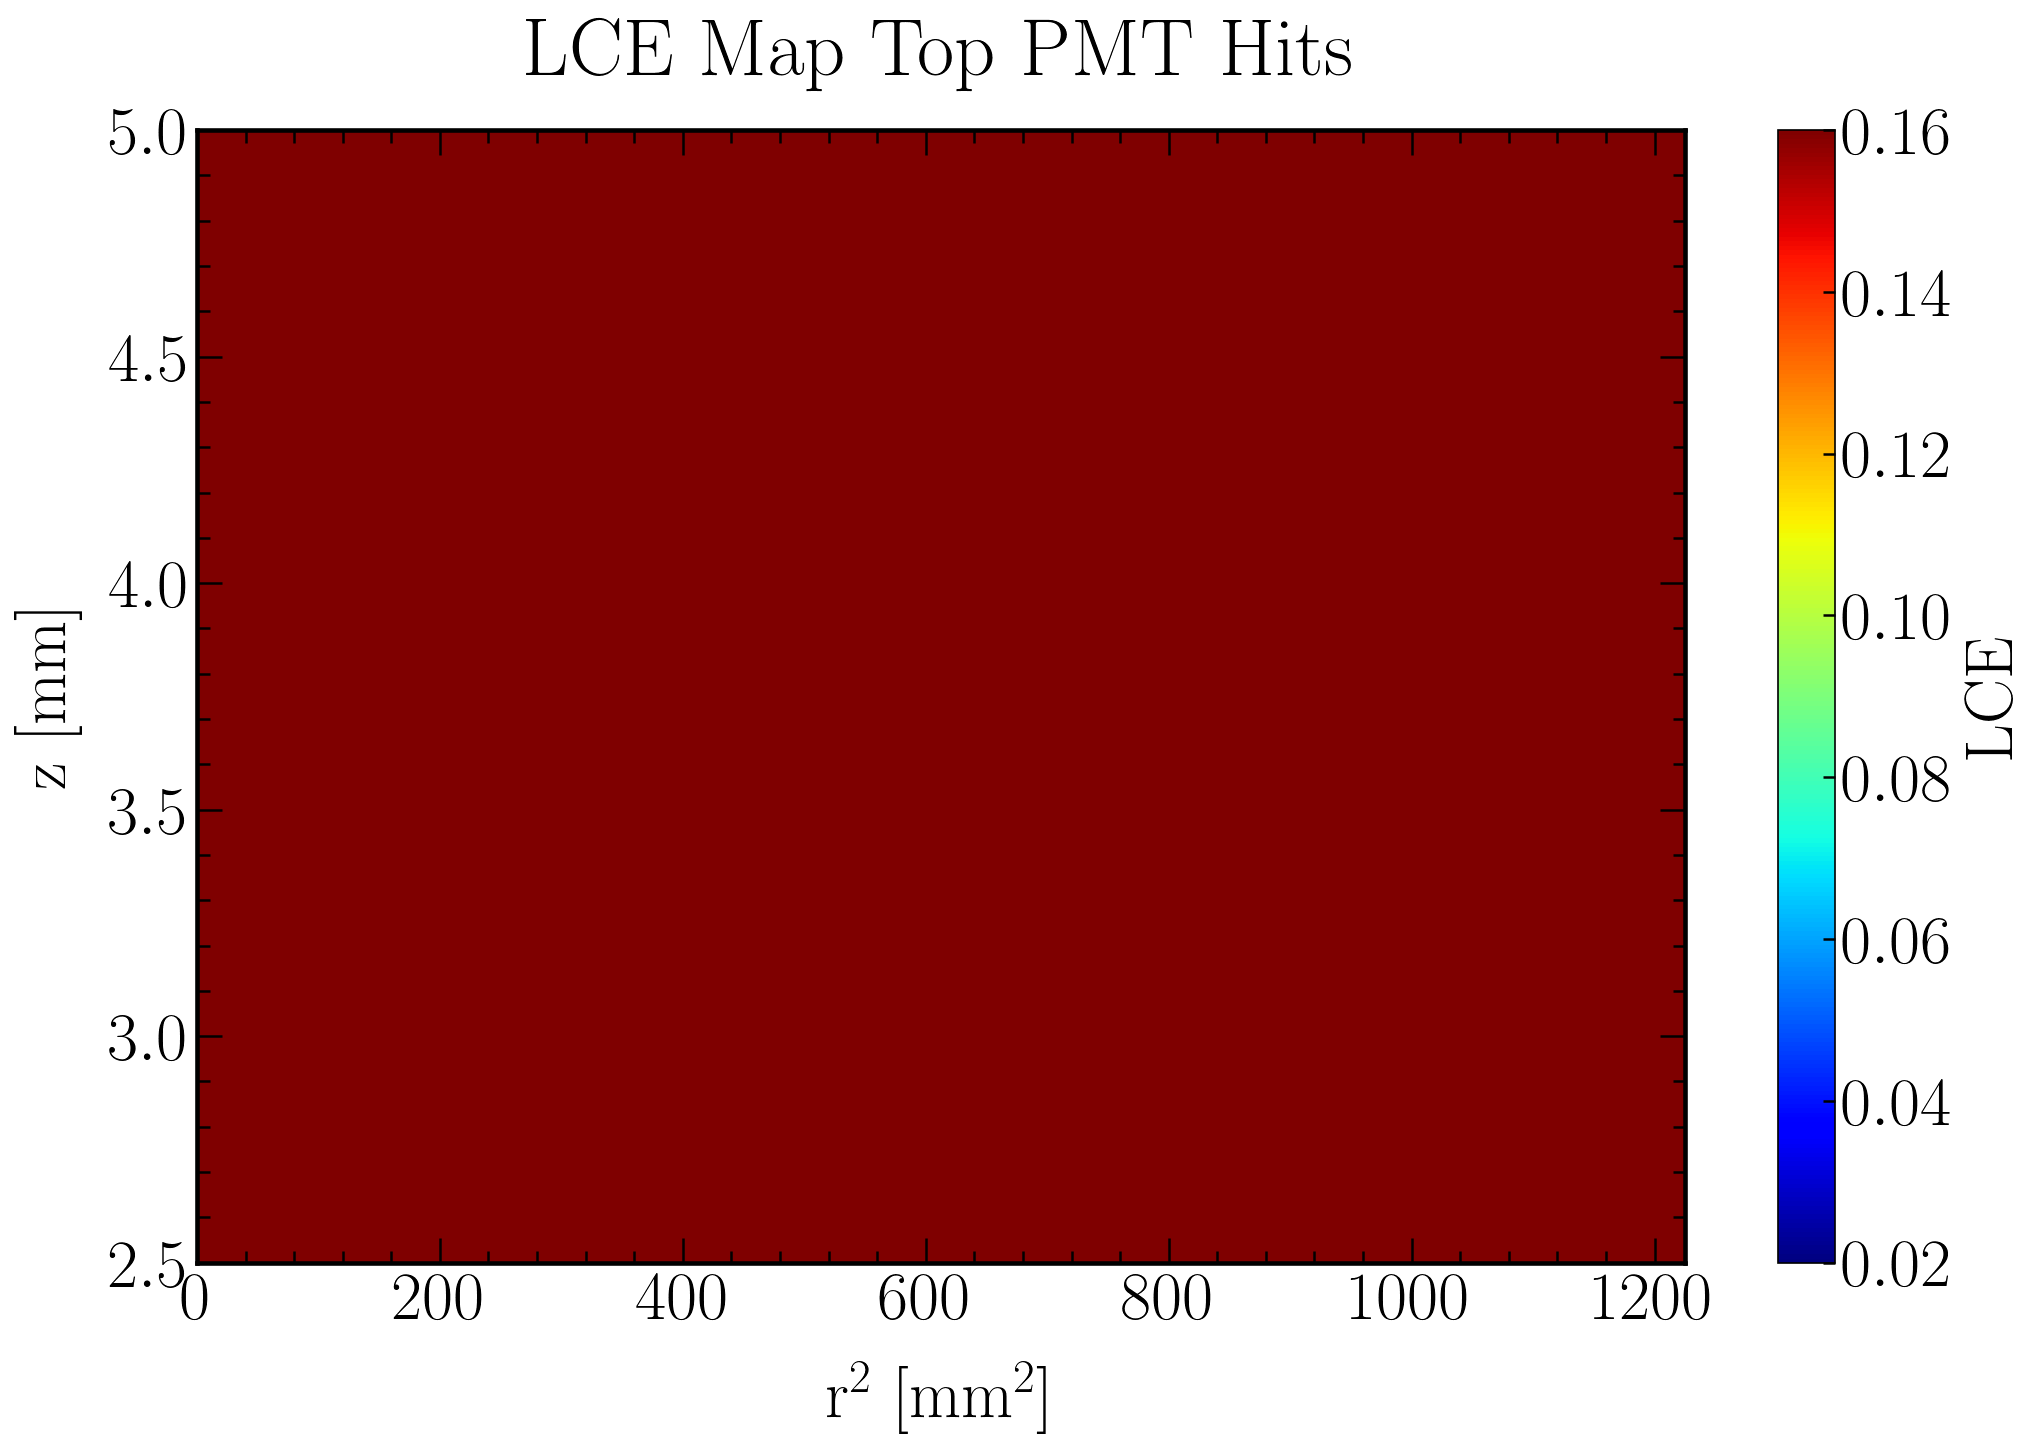

In [28]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = 35

# Data plot
plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LCEwTop*(numberbins*numberbins), cmap = 'jet')#, normed = True, norm=LogNorm()

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Top PMT Hits', fontsize = title_size, pad = title_pad)

#plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)
plt.clim(0.02, 0.16)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Top_scaled.png")
plt.show()

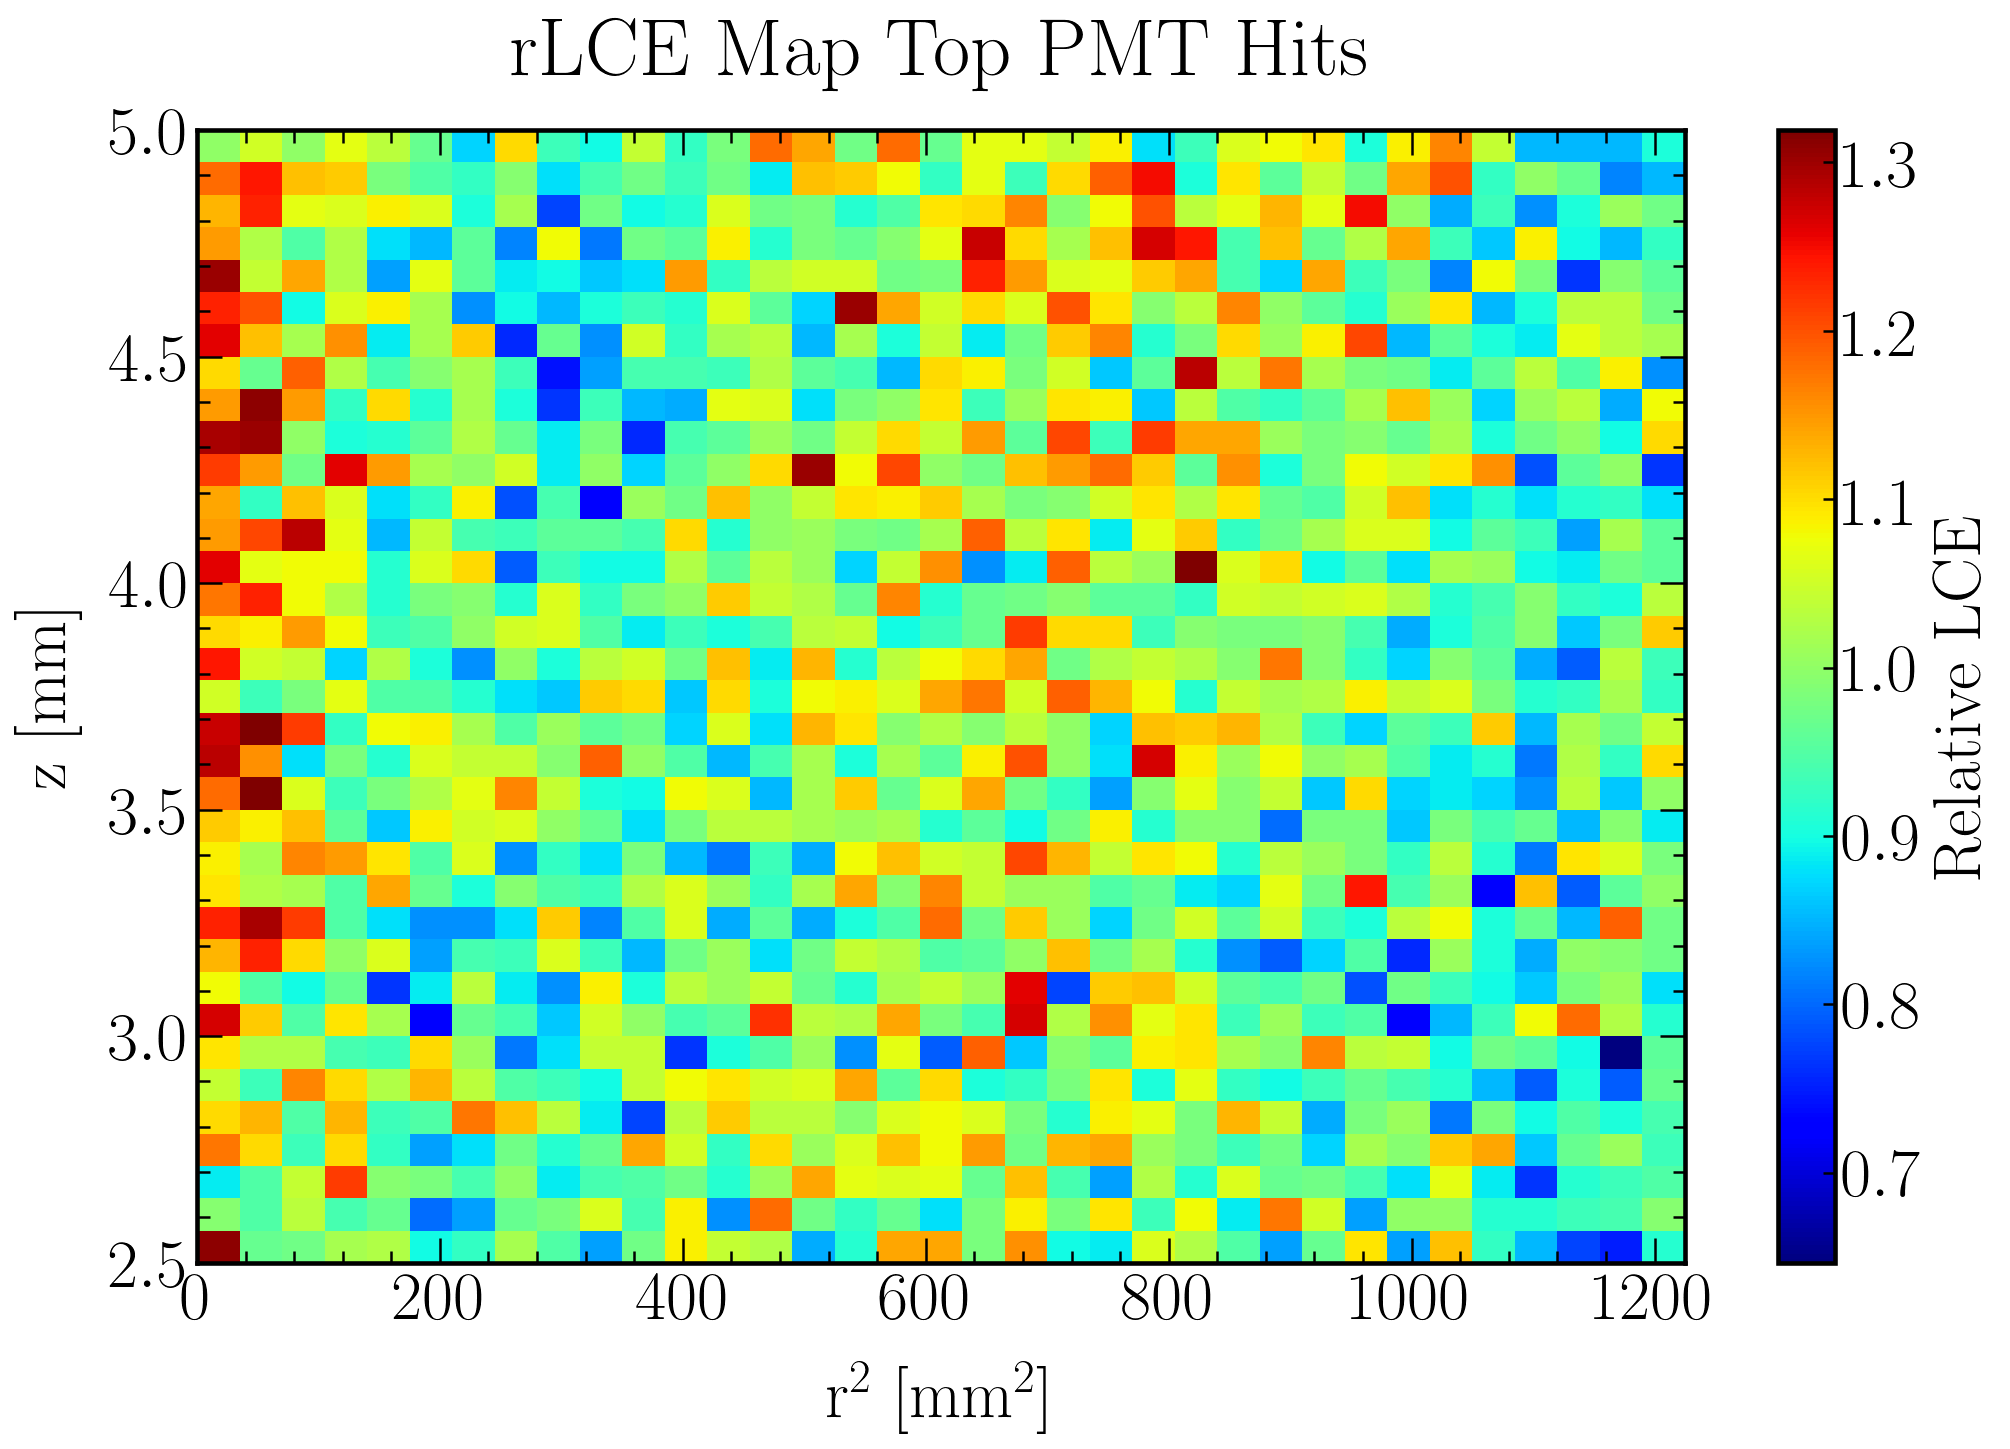

In [29]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = 35

# Data plot
plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.ntpmthits/(ntpmthits_sum/(numberbins*numberbins)), cmap = 'jet')#, normed = True, norm=LogNorm()

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('rLCE Map Top PMT Hits', fontsize = title_size, pad = title_pad)

#plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Relative LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Top_rel.png")
plt.show()

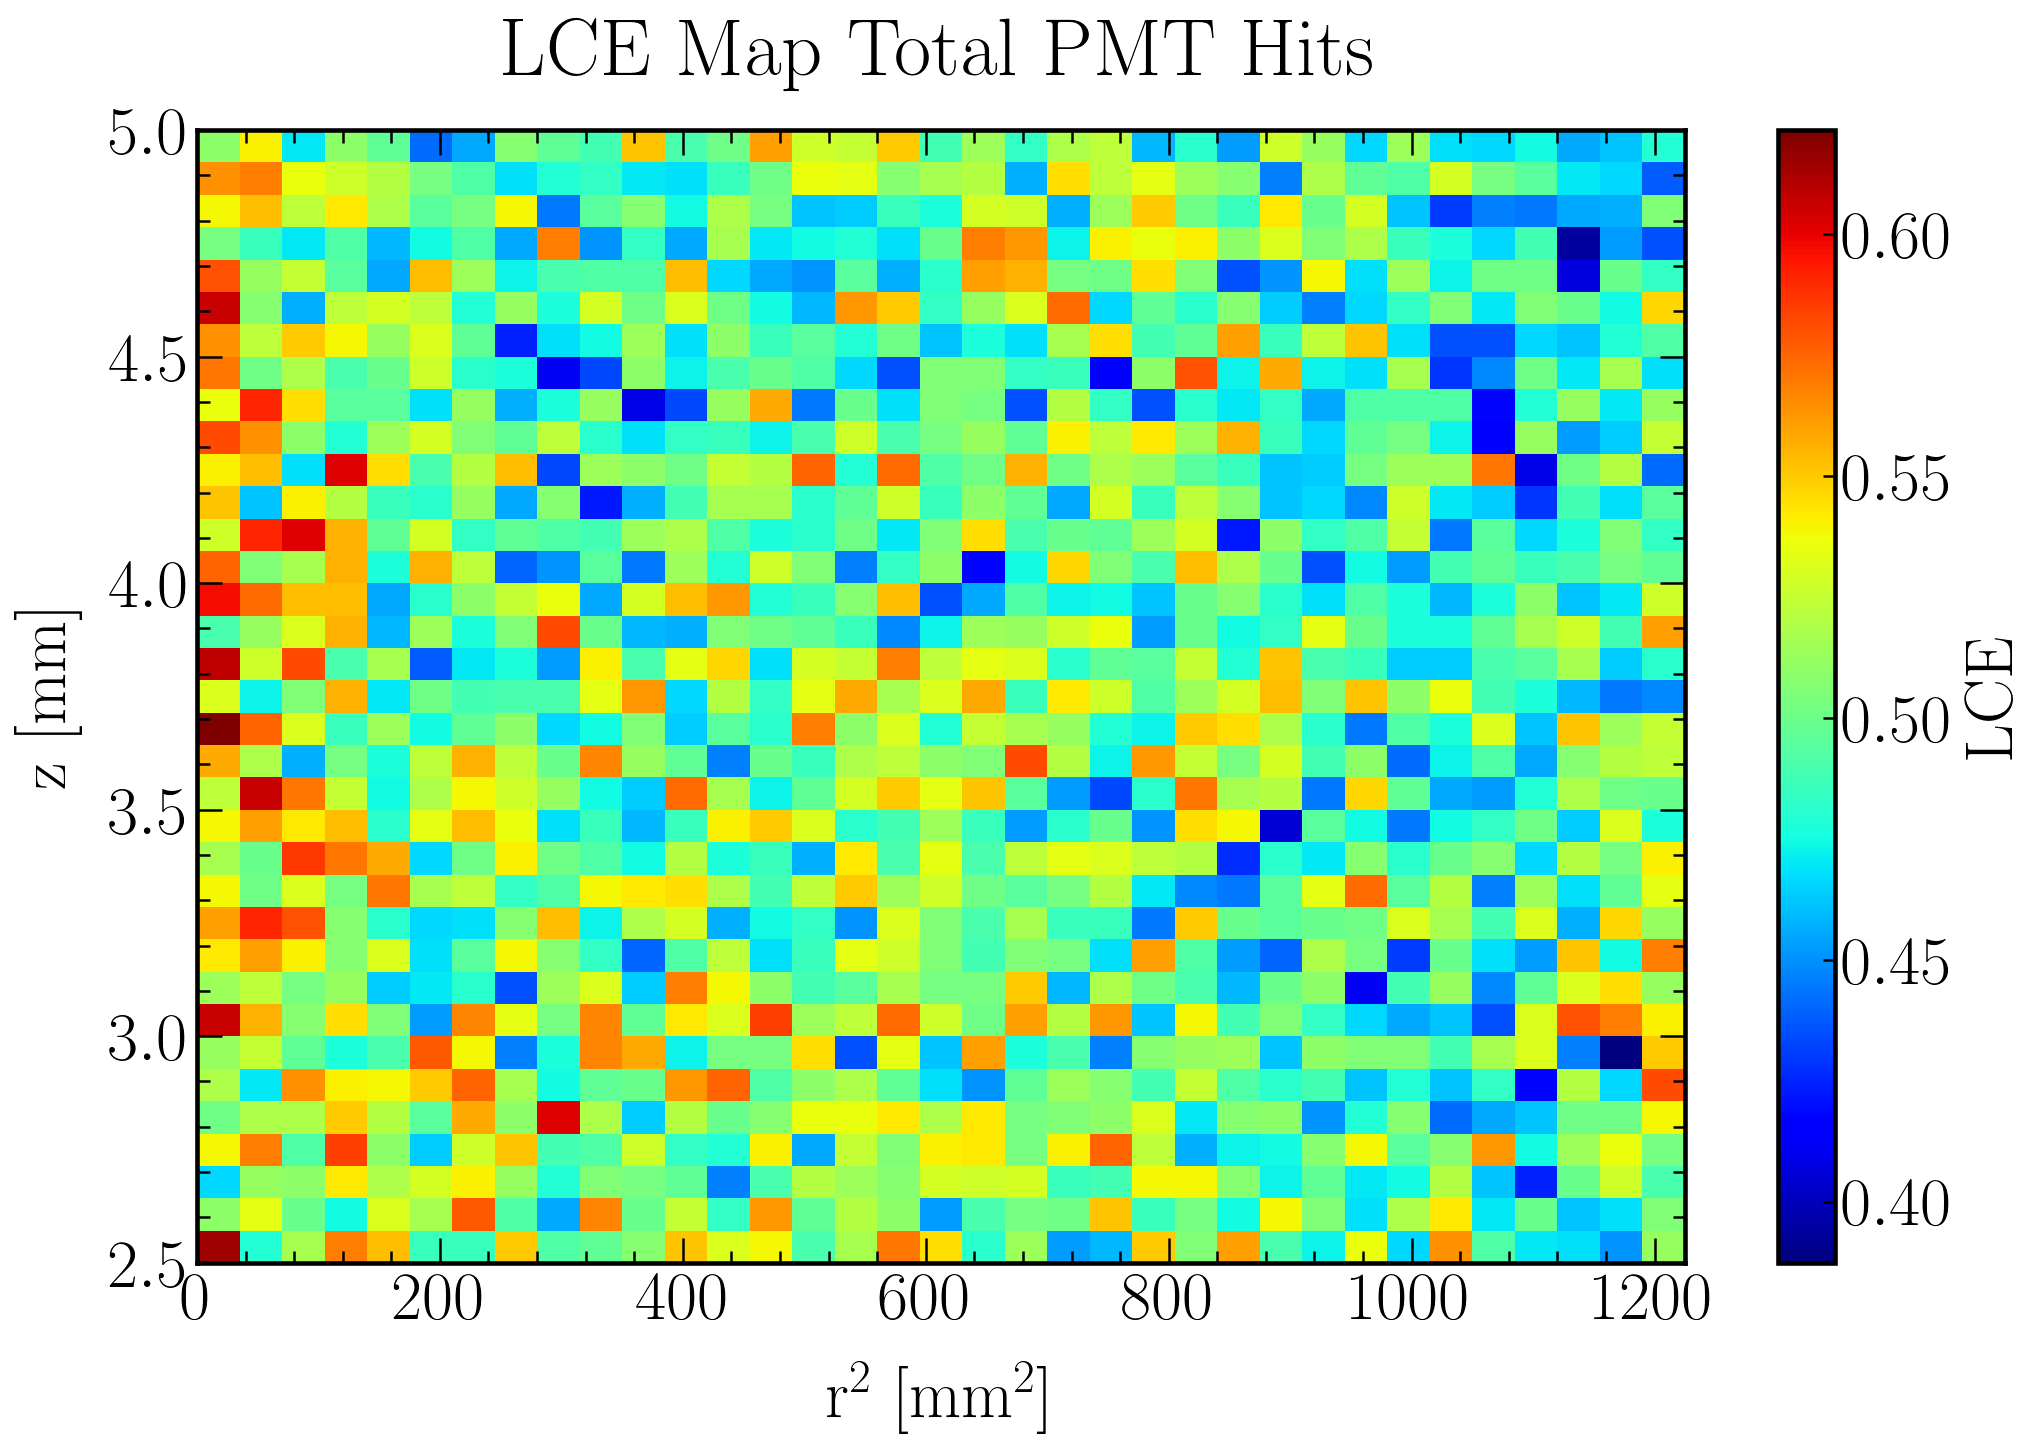

In [30]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = 35

# Data plot
plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LCEwAll*numberbins*numberbins, cmap = 'jet')#, normed = True, norm=LogNorm()

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Total PMT Hits', fontsize = title_size, pad = title_pad)

#plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Total.png")
plt.show()

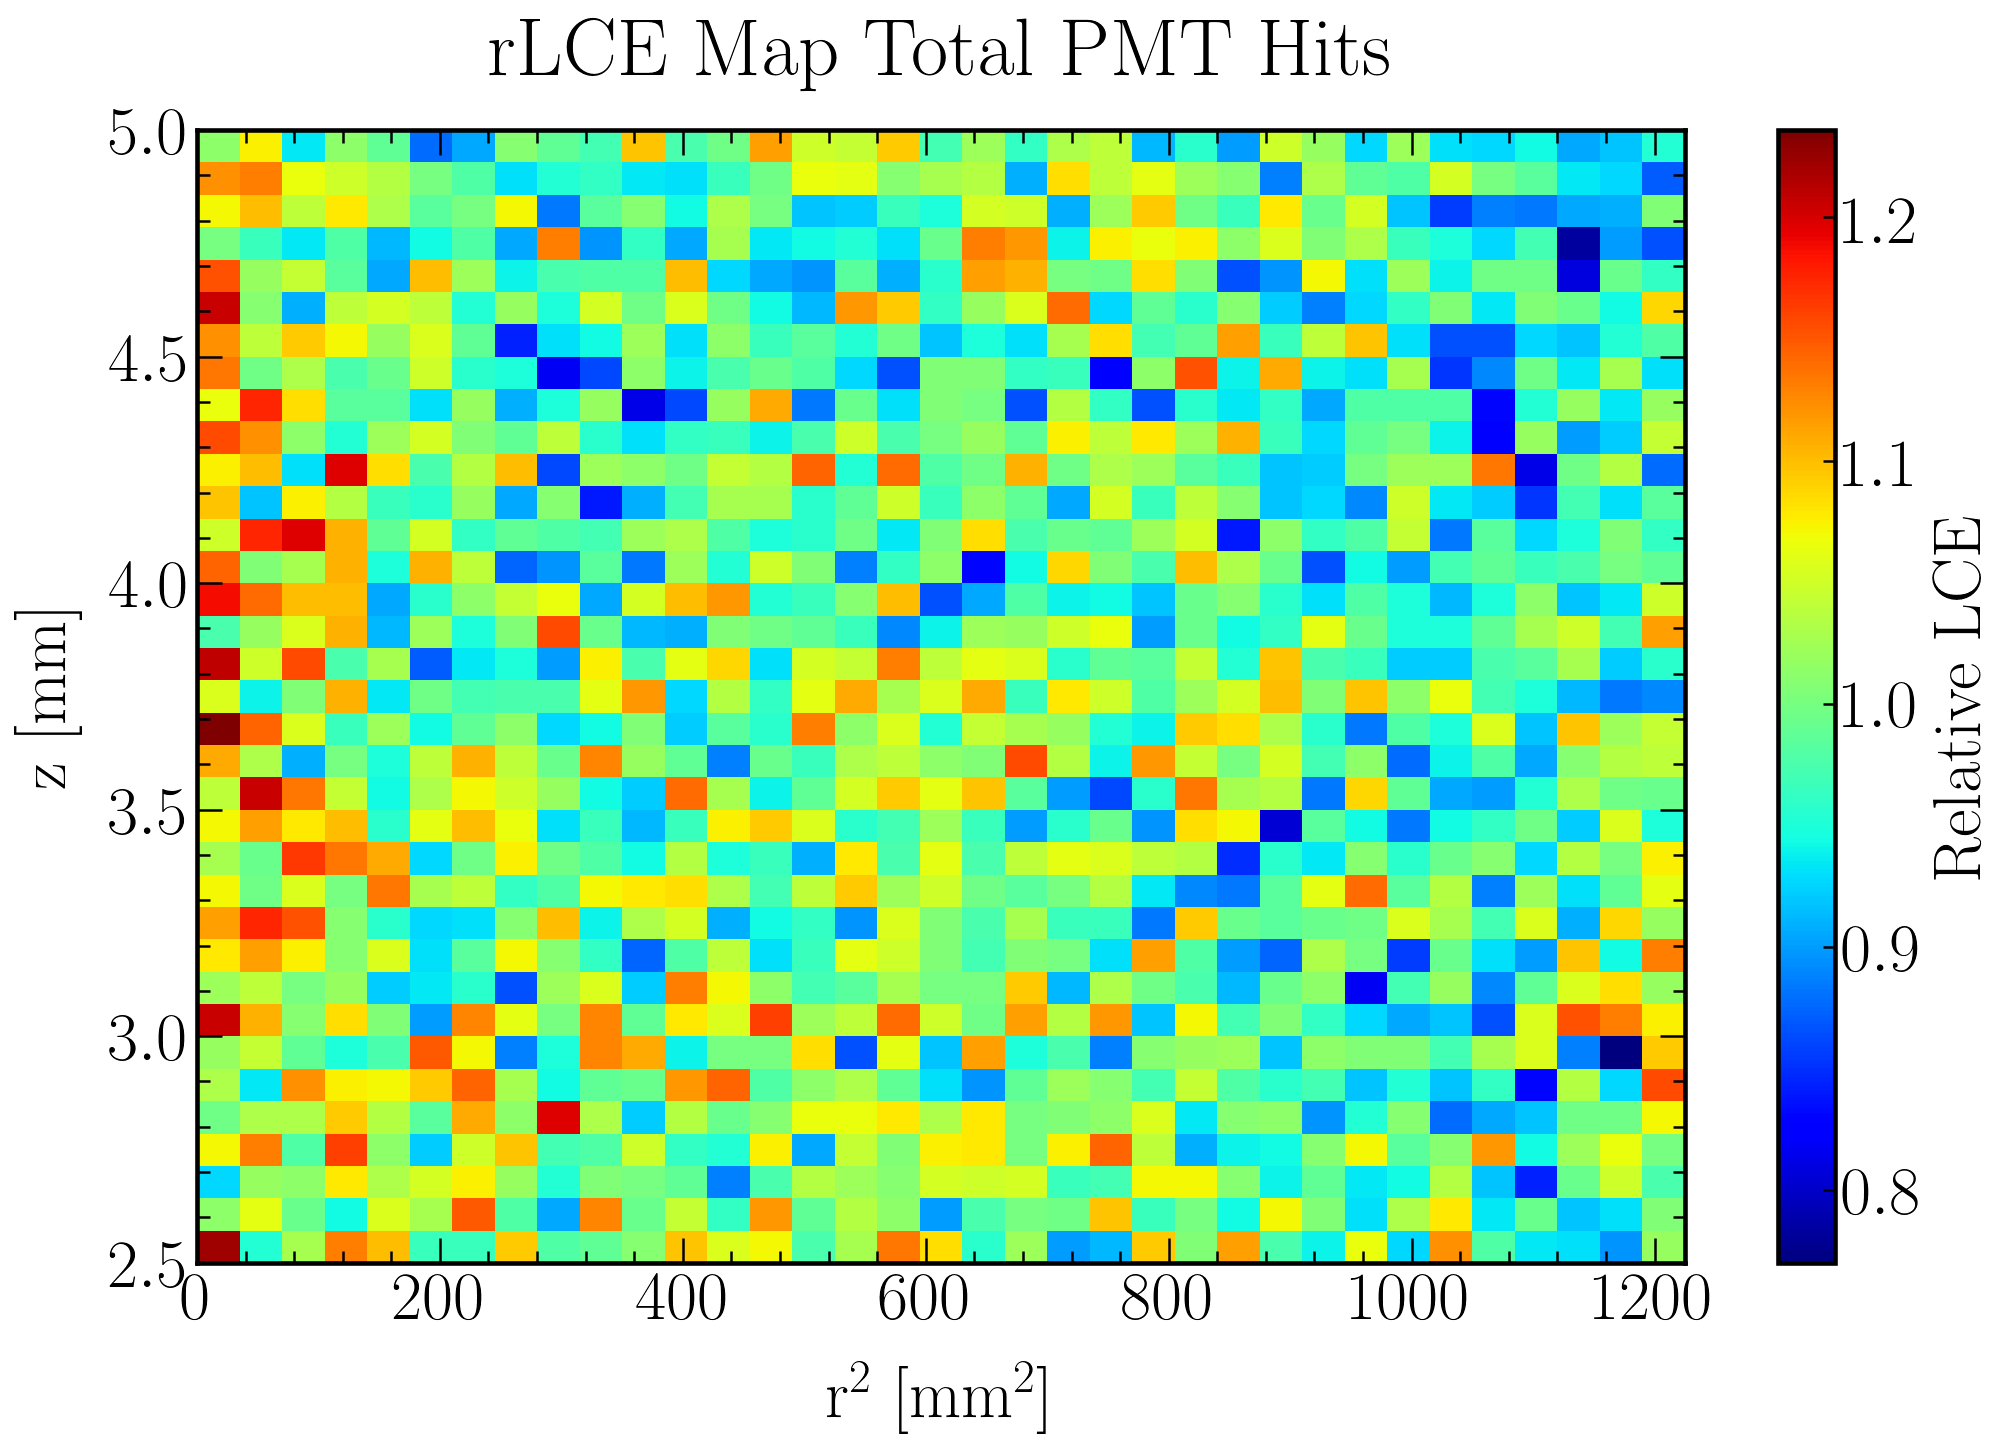

In [31]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = 35

# Data plot
plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.napmthits/(napmthits_sum/(numberbins*numberbins)), cmap = 'jet')#, normed = True, norm=LogNorm()

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('rLCE Map Total PMT Hits', fontsize = title_size, pad = title_pad)

#plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Relative LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_r2_z_Total_rel.png")
plt.show()

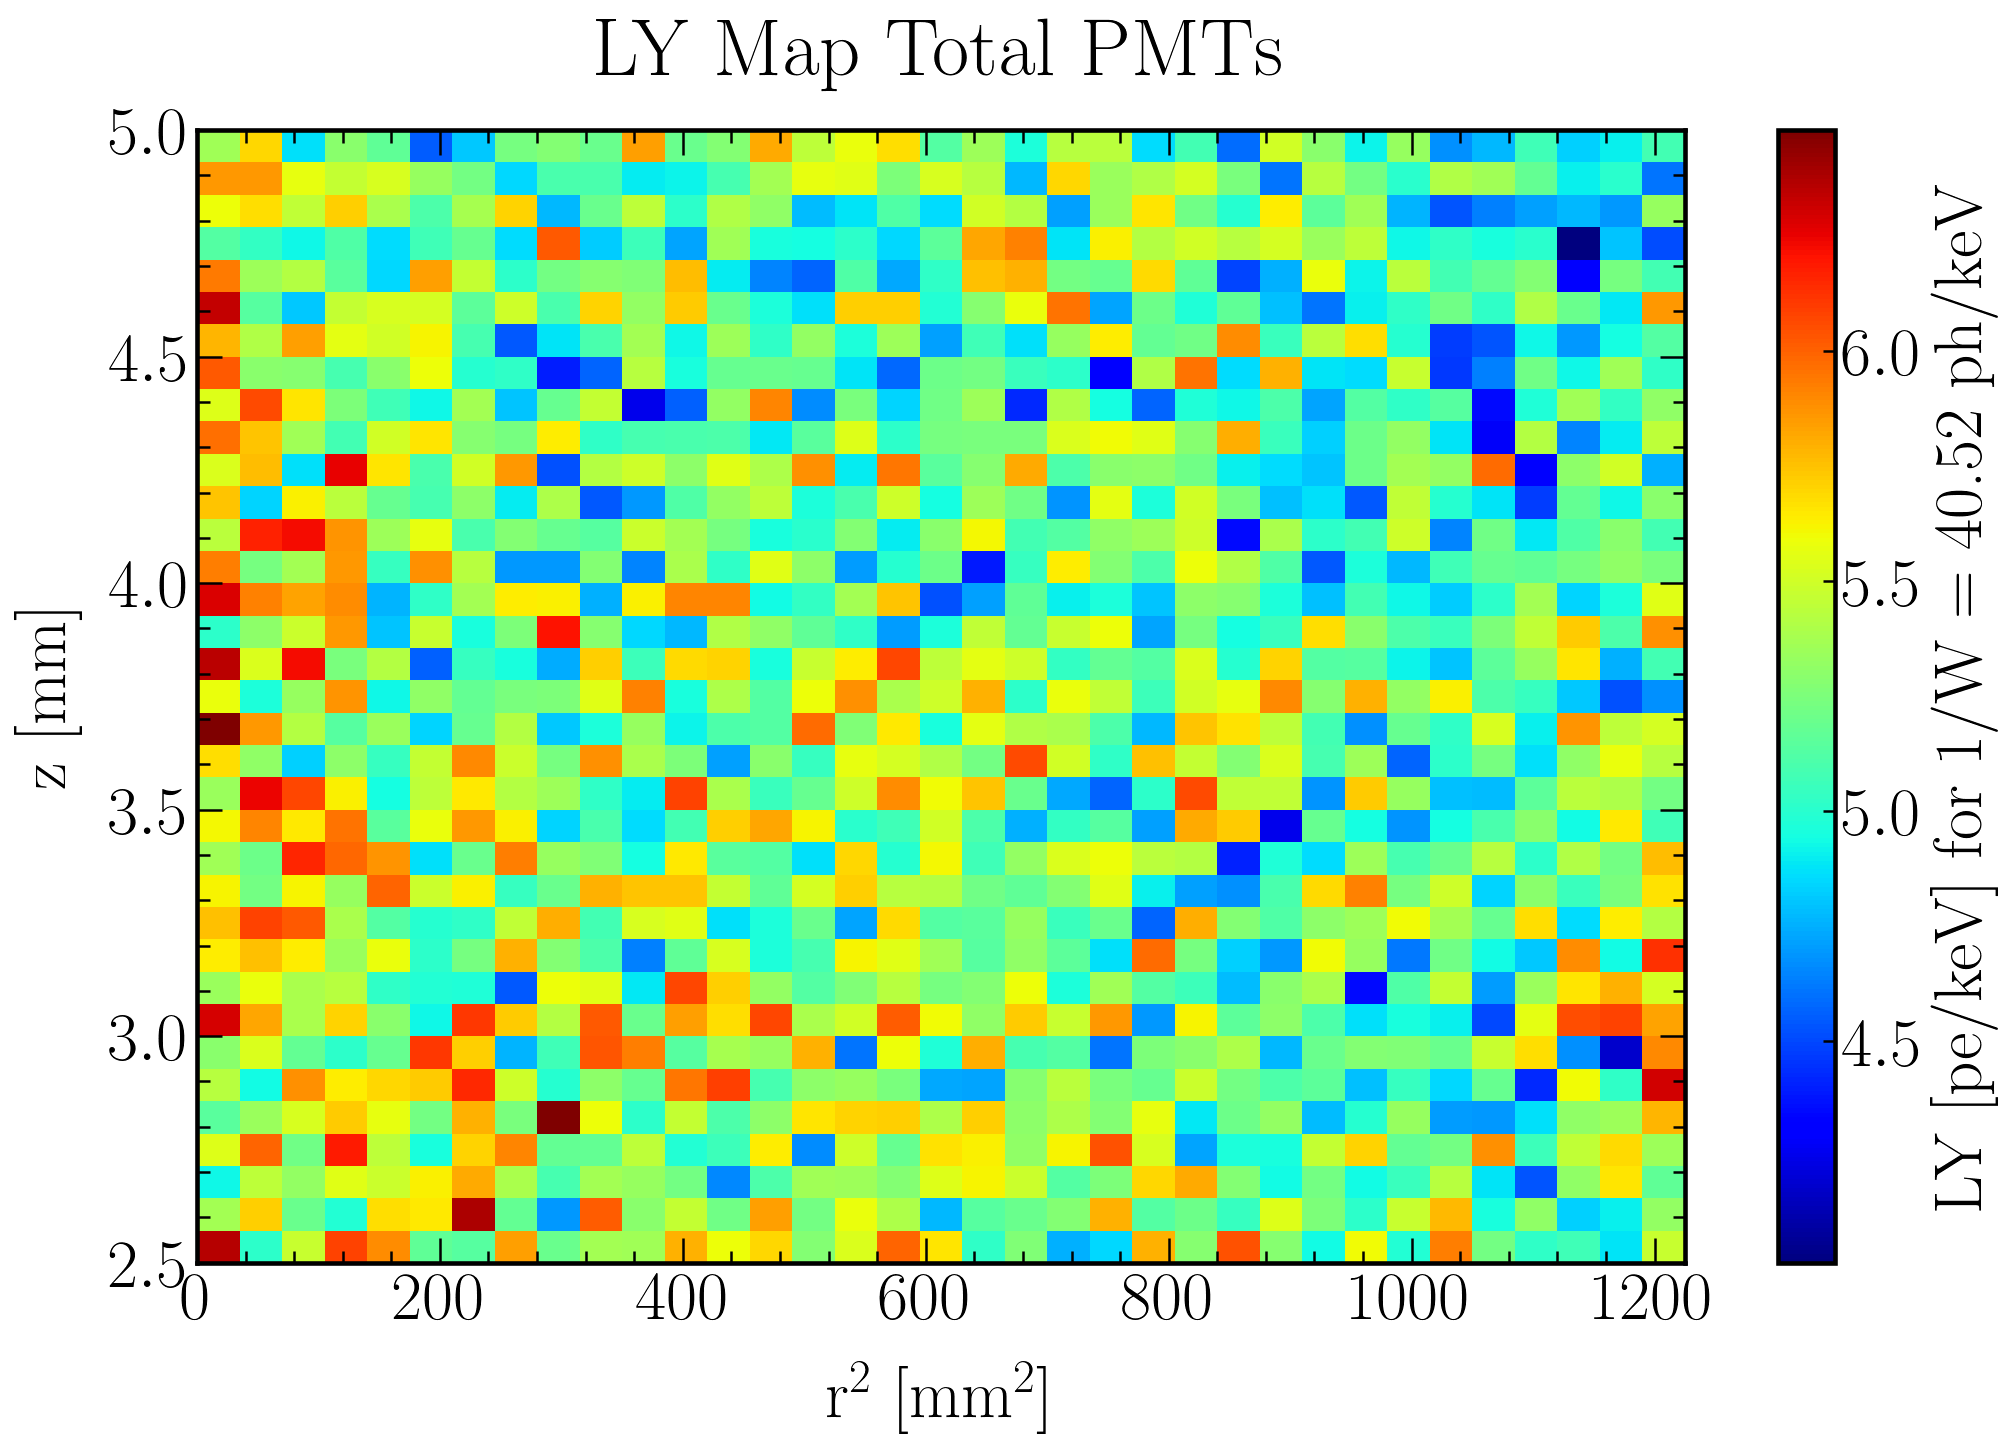

In [32]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

numberbins = 35

# Data plot
plt.hist2d(_chunk_collect.rp_pri2, _chunk_collect.zp_pri, bins=numberbins, weights = _chunk_collect.LYwAll*numberbins*numberbins, cmap = 'jet')#, normed = True, norm=LogNorm()

plt.xlabel('r$^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('z [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LY Map Total PMTs', fontsize = title_size, pad = title_pad)

#plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LY [pe/keV] for 1/W = '+str(round(1/W,2))+' ph/keV', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LY_r2_z_Total.png")
plt.show()

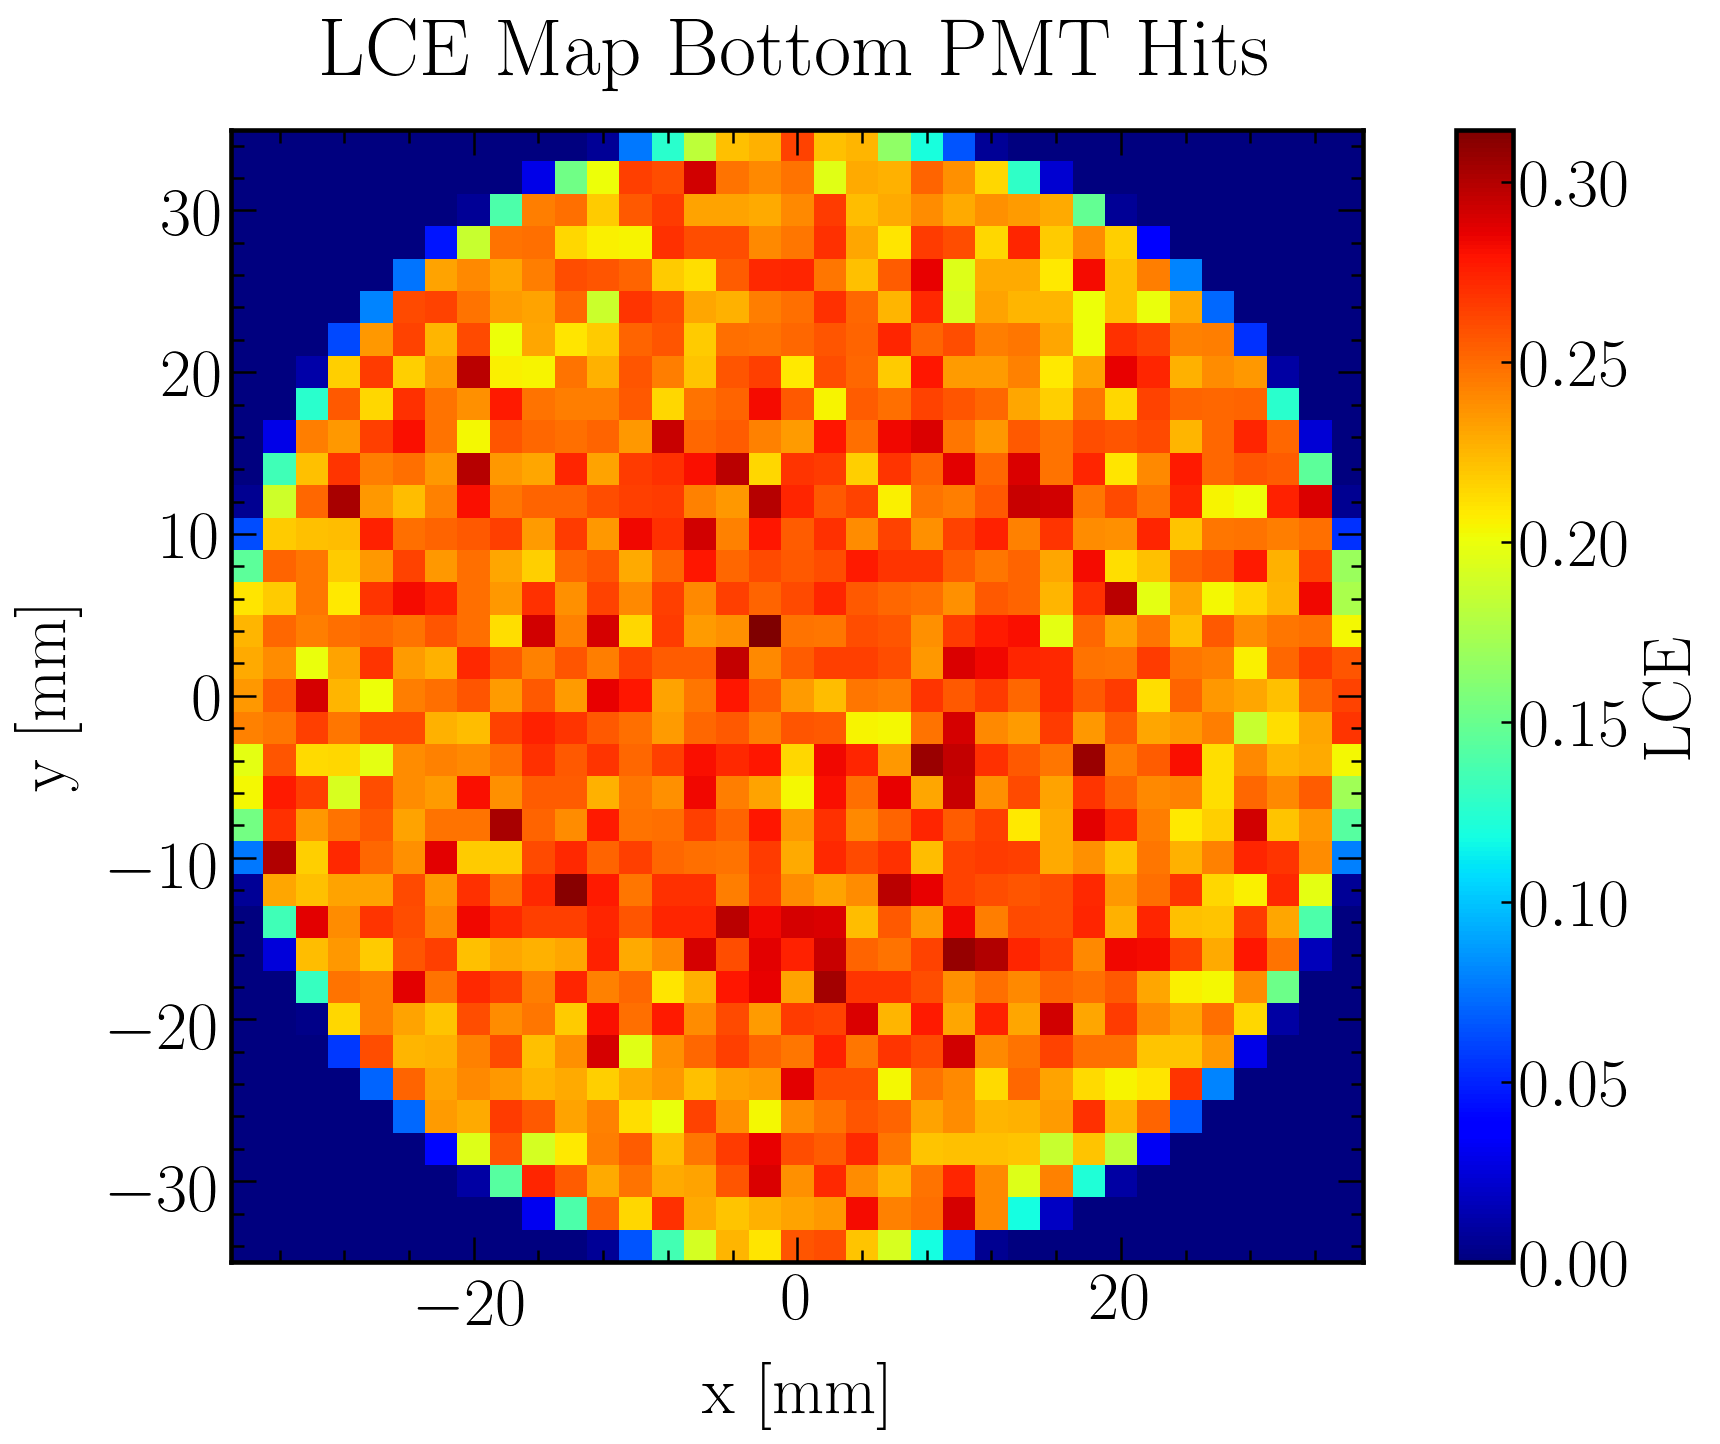

In [33]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=35, weights = _chunk_collect.LCEwBottom*numberbins*numberbins*math.pi/4, cmap = 'jet')#, normed = True, norm=LogNorm()

plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Bottom PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_x_y_Bottom.png")
plt.show()

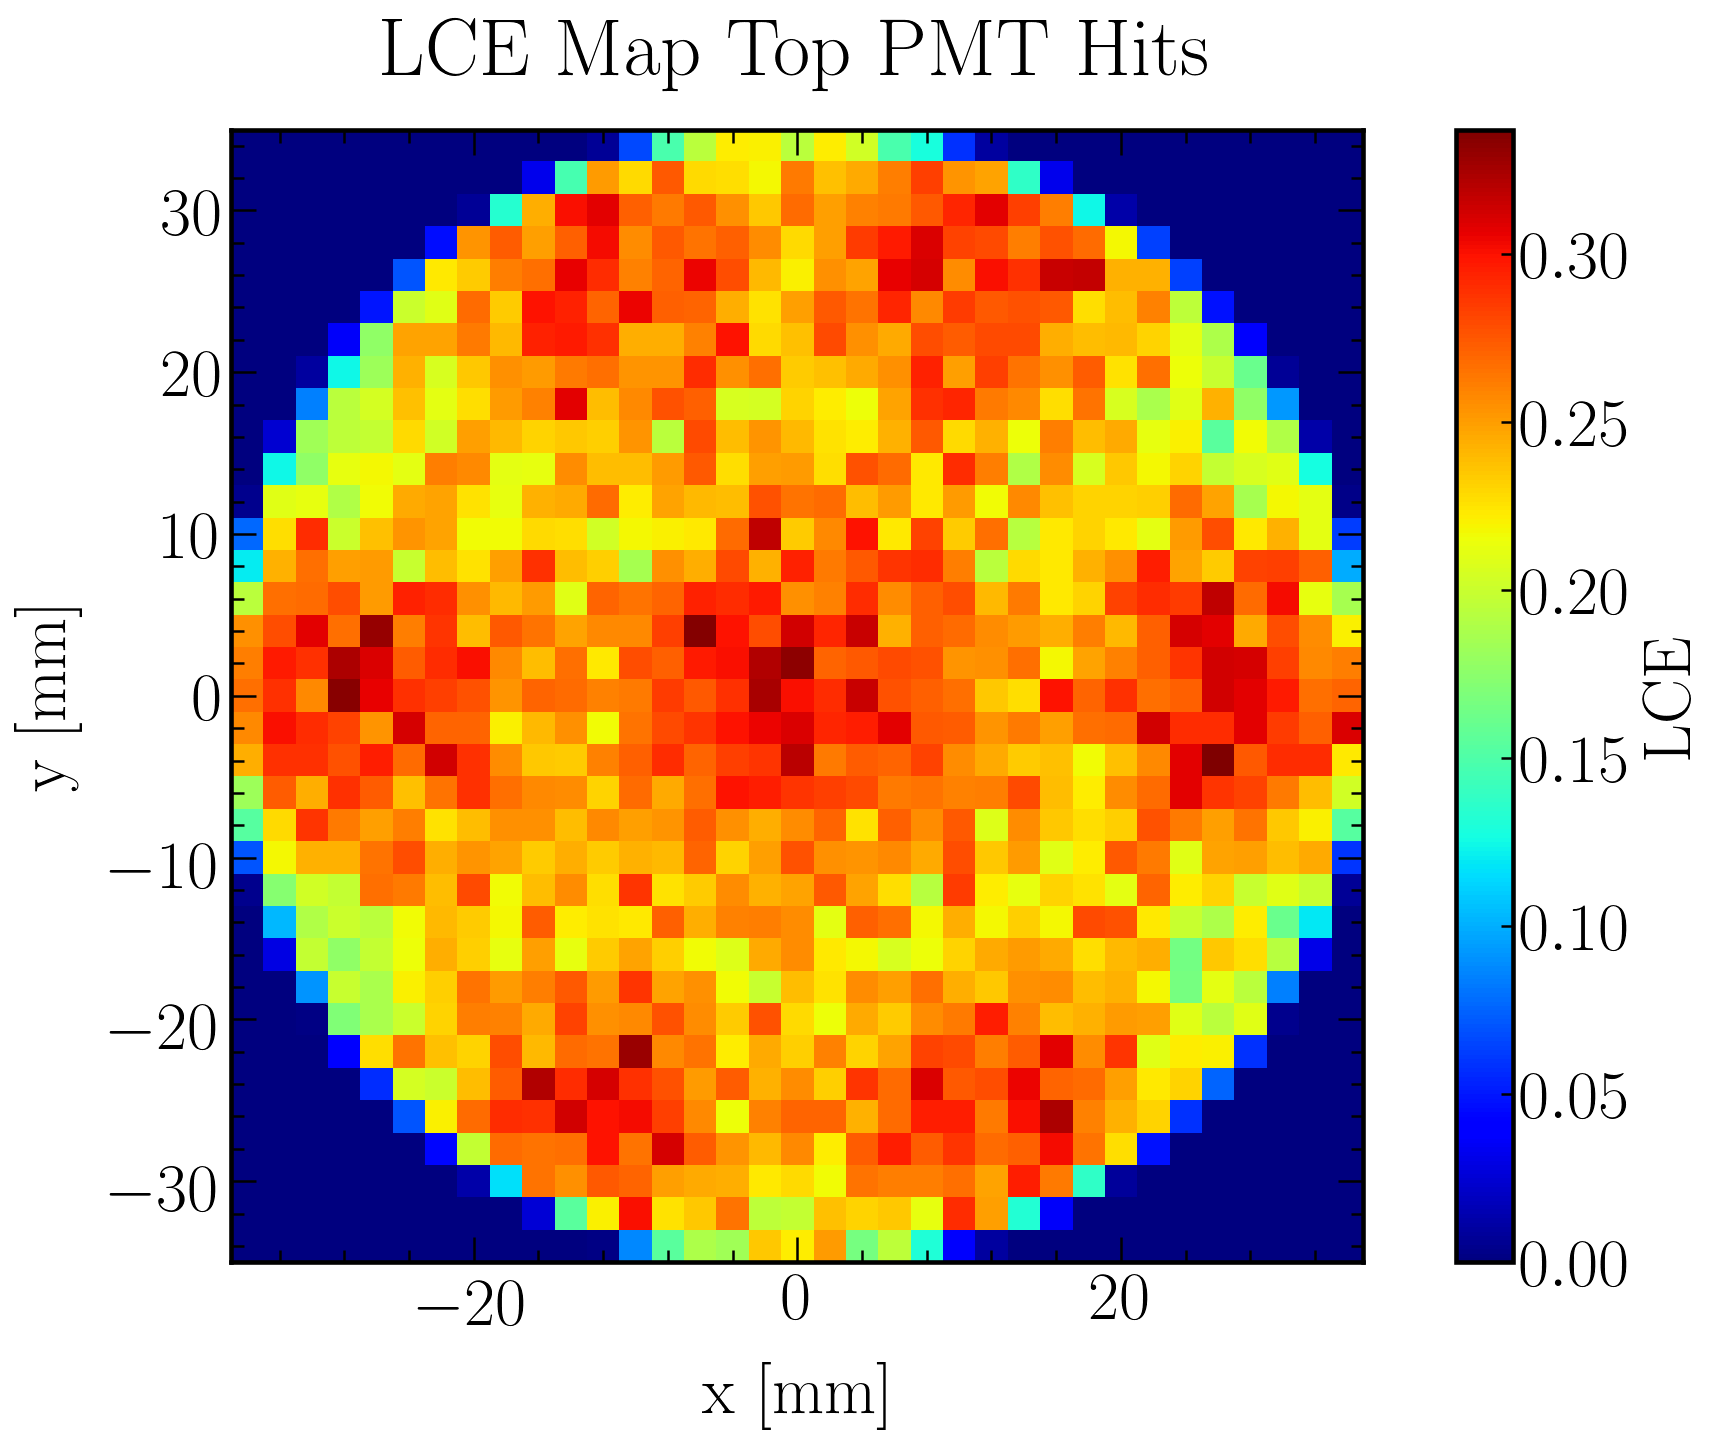

In [34]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=35, weights = _chunk_collect.LCEwTop*numberbins*numberbins*math.pi/4, cmap = 'jet')#, normed = True, norm=LogNorm()

plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Top PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_x_y_Top.png")
plt.show()

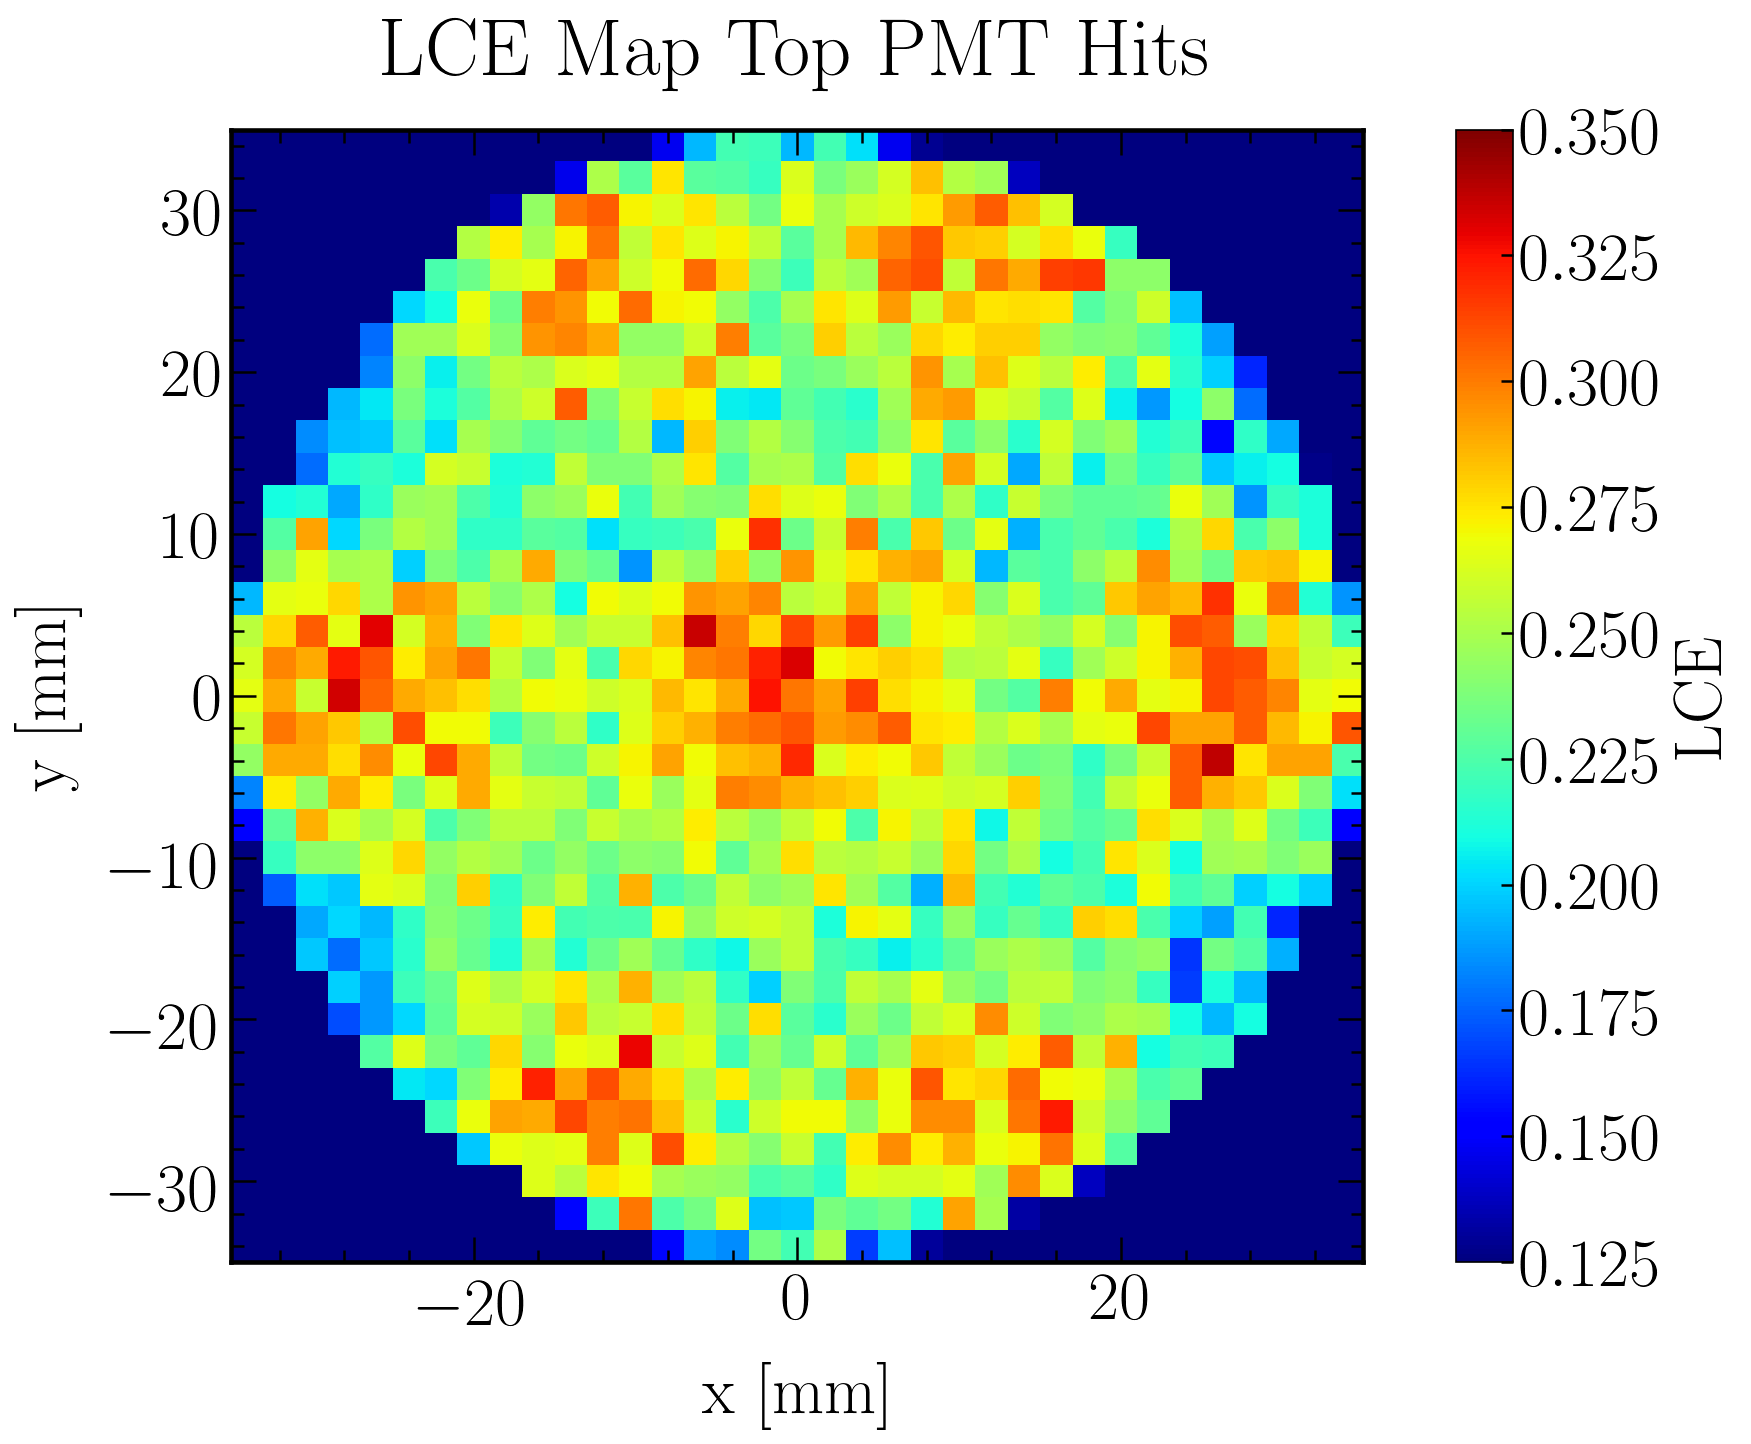

In [35]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=35, weights = _chunk_collect.LCEwTop*numberbins*numberbins*math.pi/4, cmap = 'jet')#, normed = True, norm=LogNorm()

plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Top PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)
plt.clim(0.125, 0.35)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_x_y_Top_scaled.png")
plt.show()

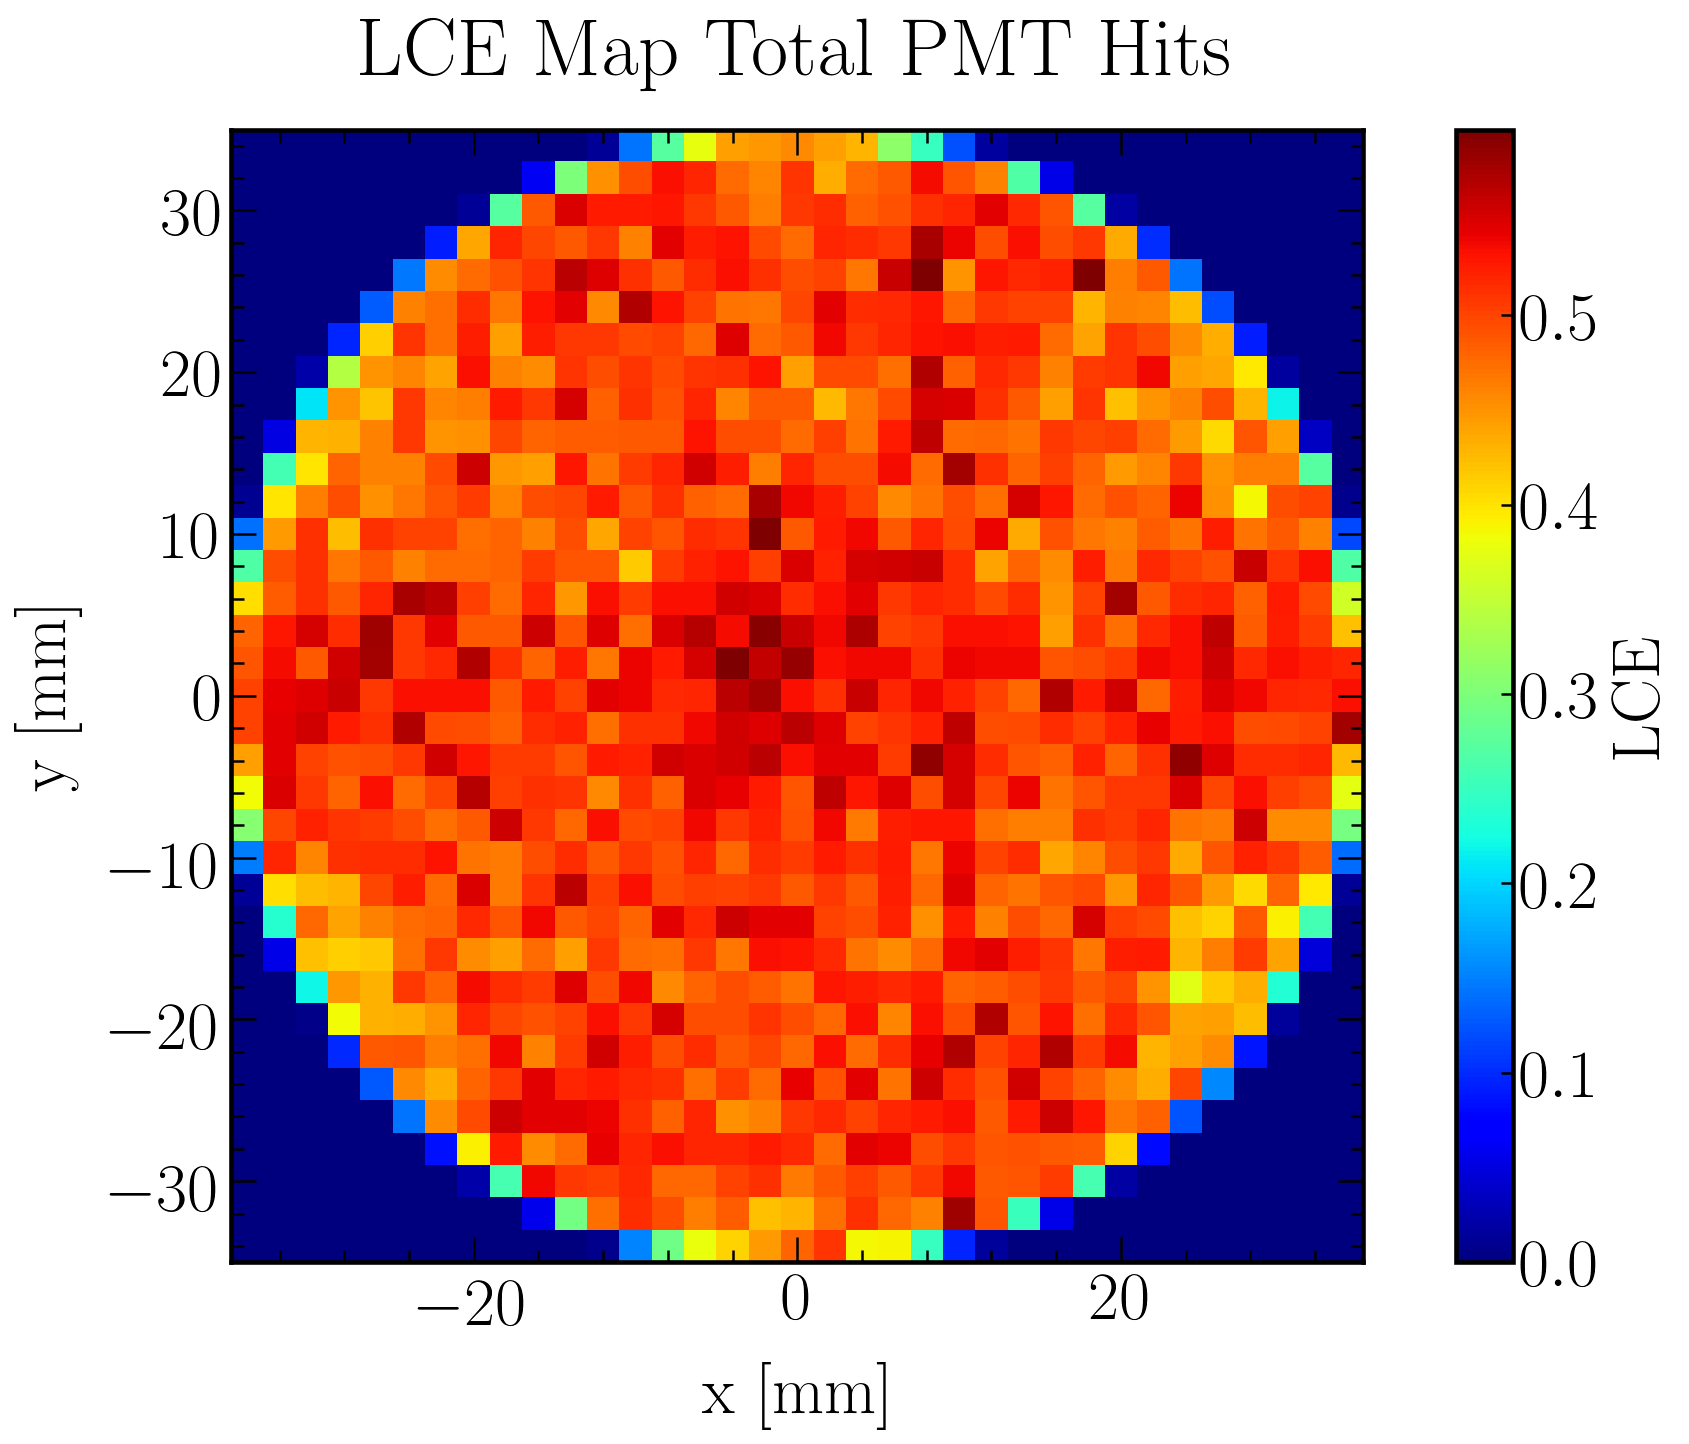

In [36]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.hist2d(_chunk_collect.xp_pri, _chunk_collect.yp_pri, bins=35, weights = _chunk_collect.LCEwAll*numberbins*numberbins*math.pi/4, cmap = 'jet')#, normed = True, norm=LogNorm()
#, vmin=0.2

plt.xlabel('x [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('y [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('LCE Map Total PMT Hits', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='LCE', fontsize=label_size)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

fig.savefig(filenameprefix+"_LCE_x_y_Total.png")
plt.show()

### Hits fraction per PMT

In [37]:
hitfractions = [0]*8
for i in range(0,8):
    hitfractions[i] = sum(nth_tuple_subentries(_chunk_collect.pmthits, i))/napmthits_sum
#print(hitfractions)
print(sum(hitfractions))

1.0


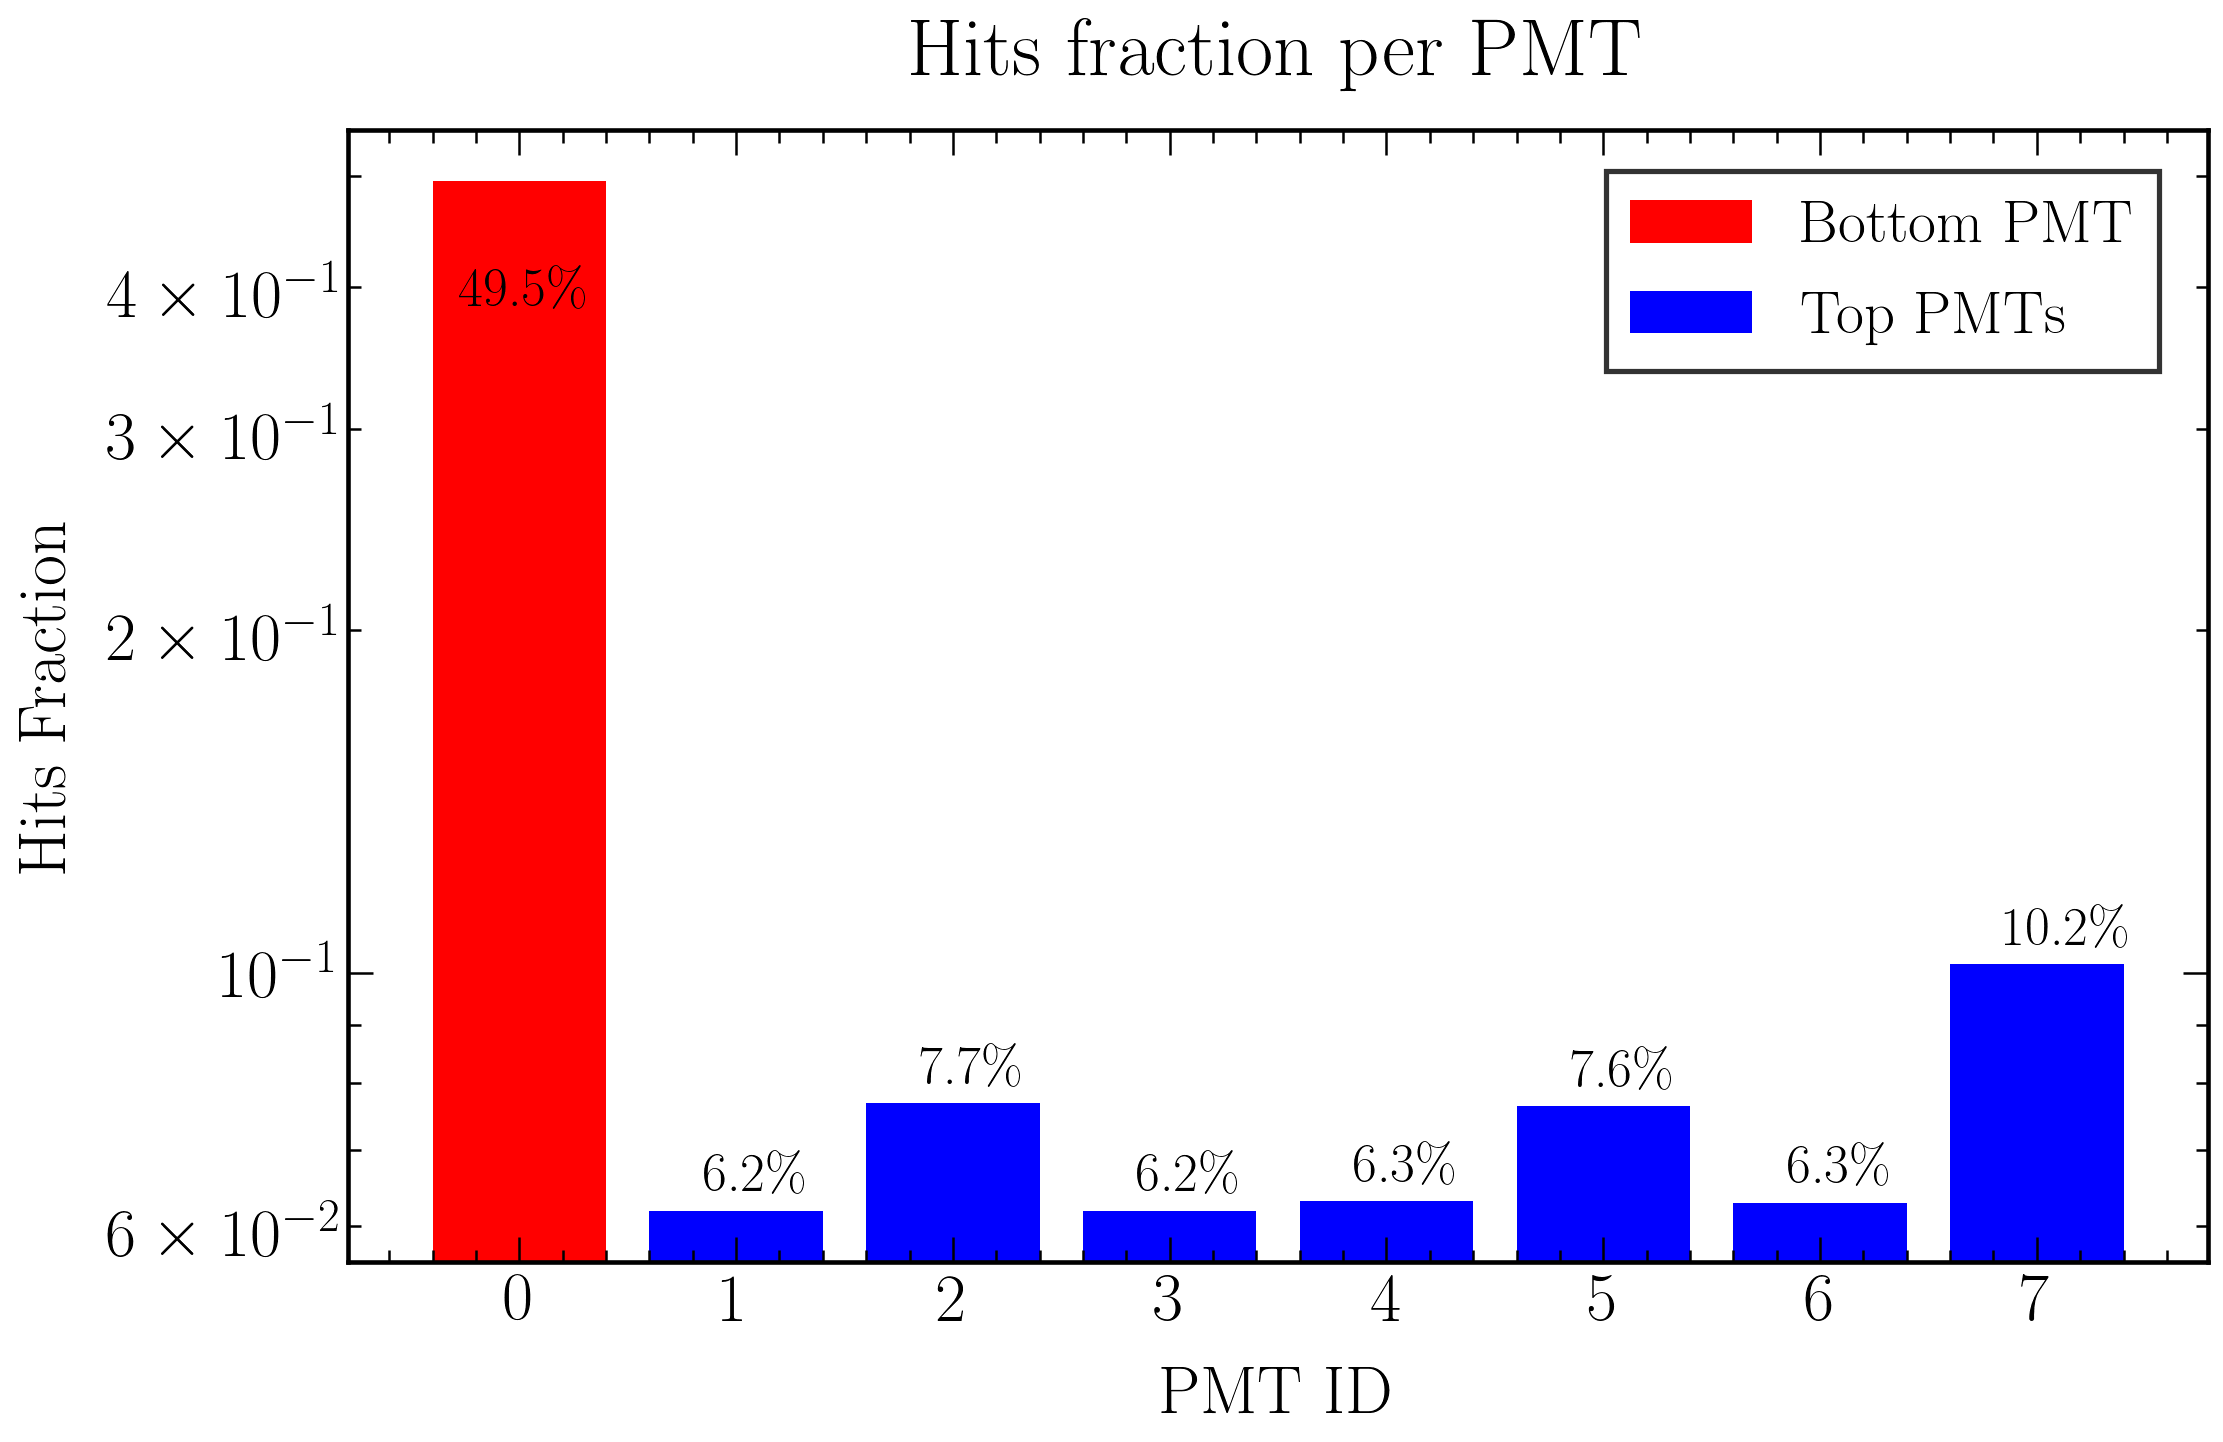

In [38]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.bar(0, hitfractions[0], color = 'red', label = 'Bottom PMT')
plt.bar(range(1,8), hitfractions[1:], color = 'blue', label = 'Top PMTs')

plt.xlabel('PMT ID', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Hits Fraction', fontsize = label_size, labelpad = label_pad)
plt.title('Hits fraction per PMT', fontsize = title_size, pad = title_pad)

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,0.45)
#plt.xlim(left=0)
plt.yscale('log', nonposy='clip')

# Label bars with values
barlabel = [str(round(100*hitfractions[0],1))+'$\%$', str(round(100*hitfractions[1],1))+'$\%$', str(round(100*hitfractions[2],1))+'$\%$', str(round(100*hitfractions[3],1))+'$\%$', str(round(100*hitfractions[4],1))+'$\%$', str(round(100*hitfractions[5],1))+'$\%$', str(round(100*hitfractions[6],1))+'$\%$', str(round(100*hitfractions[7],1))+'$\%$']
plt.text(x = -0.28 , y = (hitfractions[0])*math.log(6,10), s = barlabel[0], size = 0.8*label_size)
for i in range(1,8):
    plt.text(x = i -0.15 , y = (hitfractions[i])*math.log(11,10), s = barlabel[i], size = 0.8*label_size)

fig.savefig(filenameprefix+"_Hits_Fraction_PMTs.png")
plt.show()

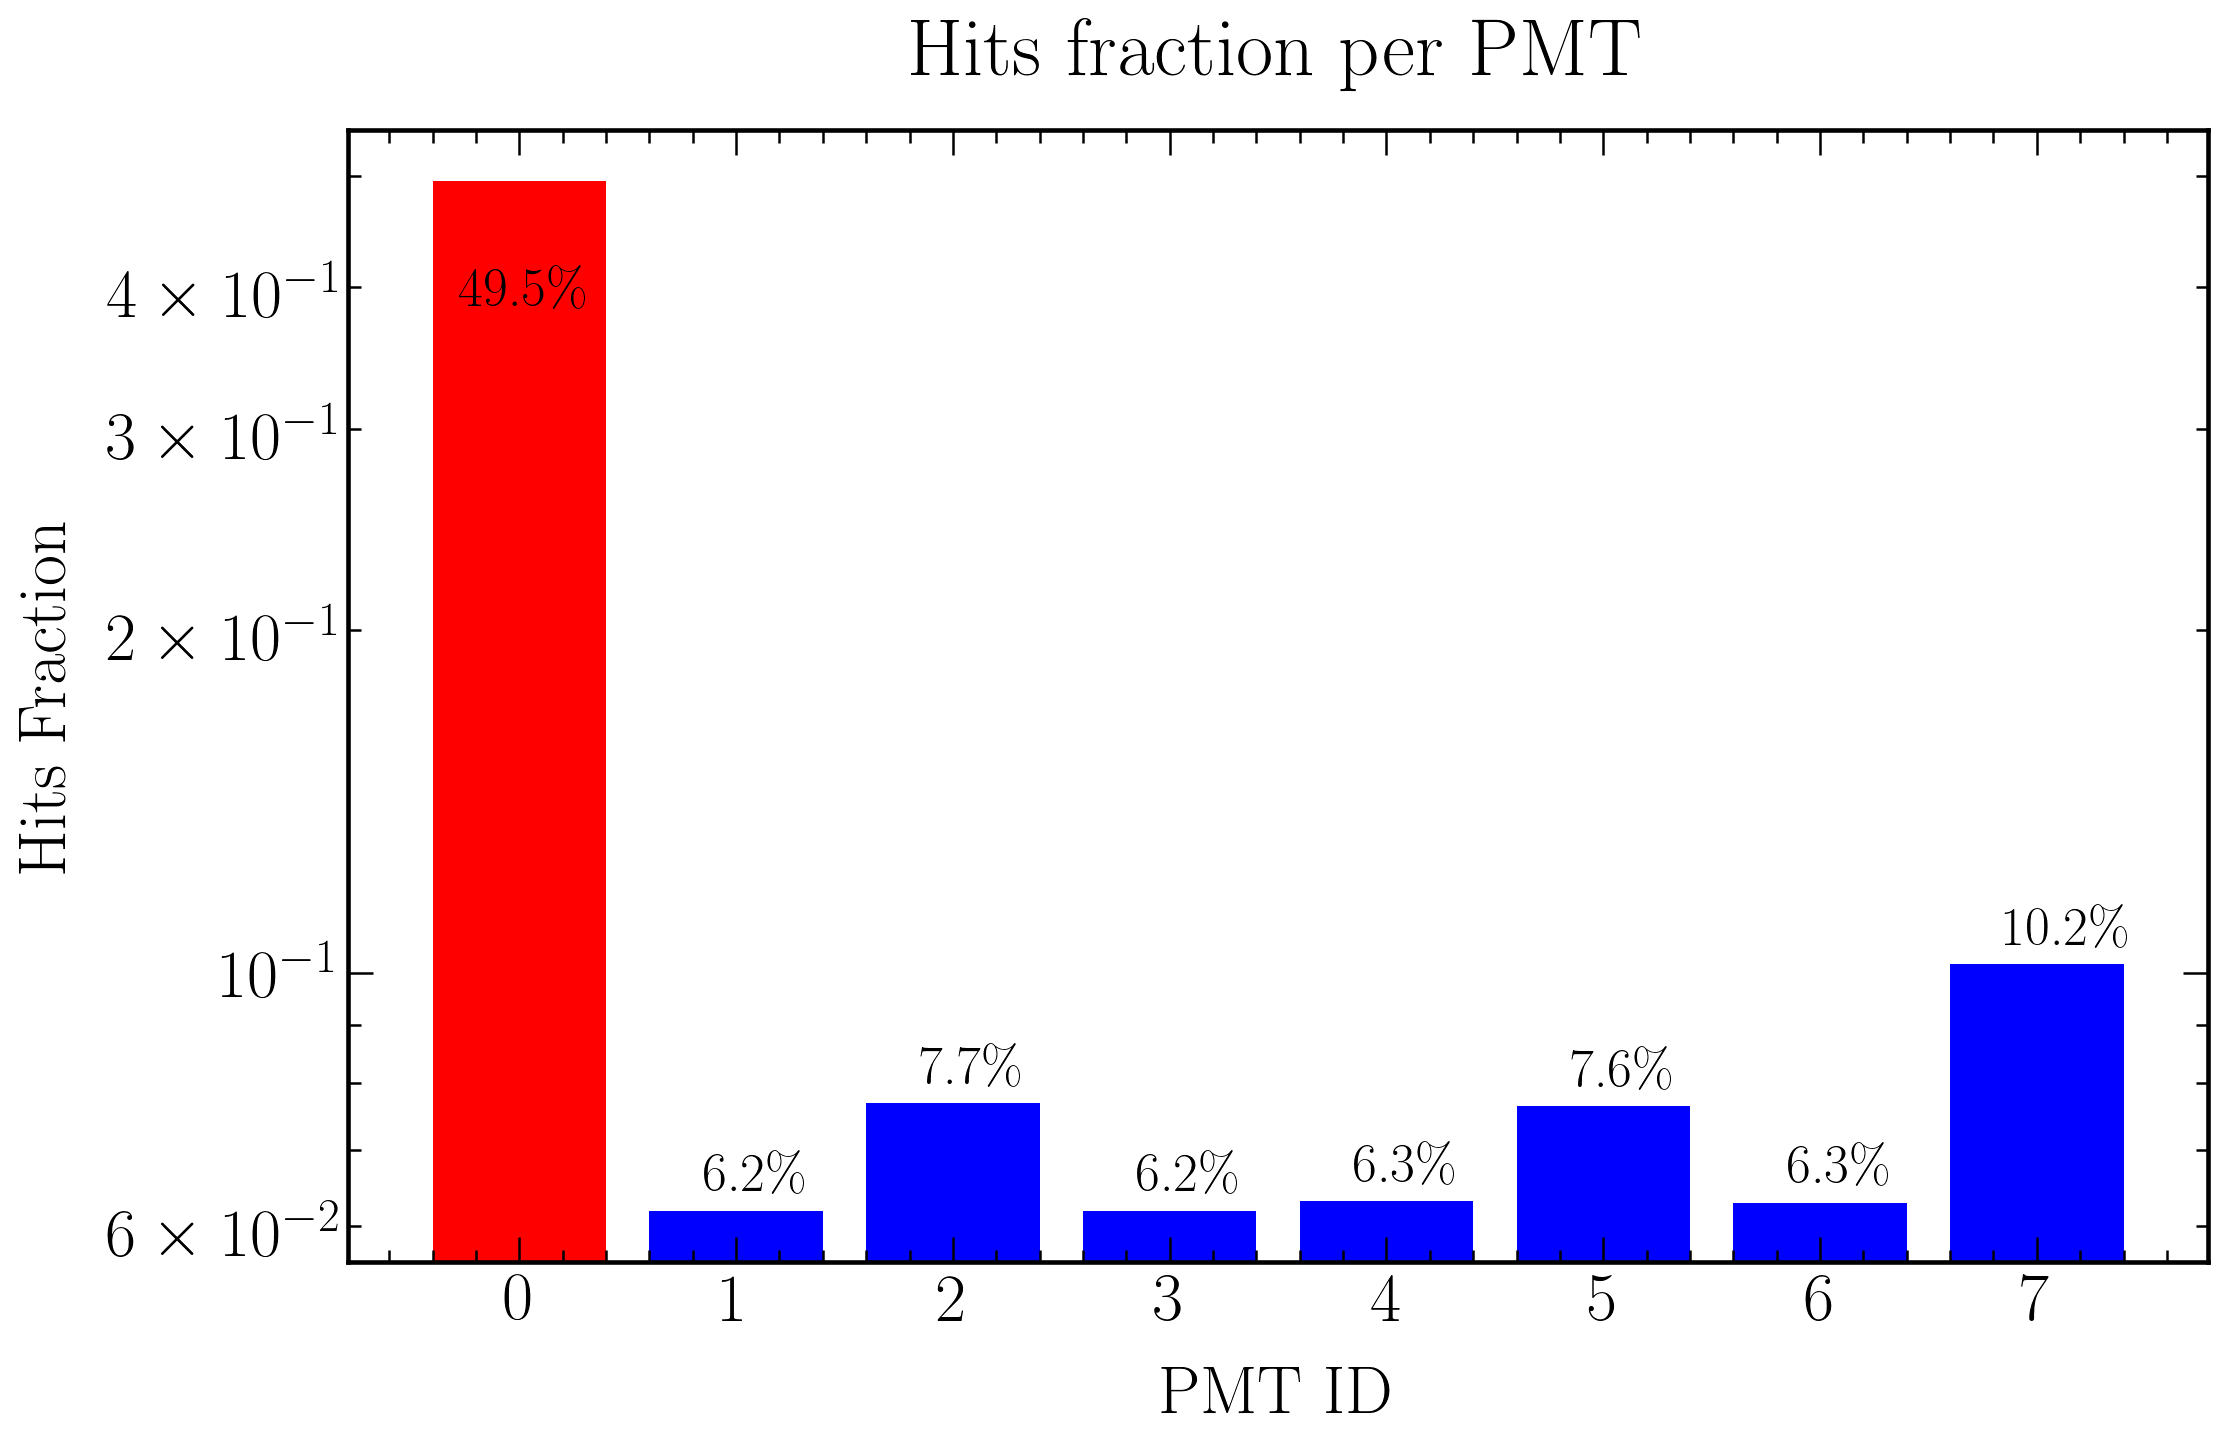

In [39]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.bar(0, hitfractions[0], color = 'red', label = 'Bottom PMT')
plt.bar(range(1,8), hitfractions[1:], color = 'blue', label = 'Top PMTs')

plt.xlabel('PMT ID', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Hits Fraction', fontsize = label_size, labelpad = label_pad)
plt.title('Hits fraction per PMT', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,0.45)
#plt.xlim(left=0)
plt.yscale('log', nonposy='clip')

# Label bars with values
barlabel = [str(round(100*hitfractions[0],1))+'$\%$', str(round(100*hitfractions[1],1))+'$\%$', str(round(100*hitfractions[2],1))+'$\%$', str(round(100*hitfractions[3],1))+'$\%$', str(round(100*hitfractions[4],1))+'$\%$', str(round(100*hitfractions[5],1))+'$\%$', str(round(100*hitfractions[6],1))+'$\%$', str(round(100*hitfractions[7],1))+'$\%$']
plt.text(x = -0.28 , y = (hitfractions[0])*math.log(6,10), s = barlabel[0], size = 0.8*label_size)
for i in range(1,8):
    plt.text(x = i -0.15 , y = (hitfractions[i])*math.log(11,10), s = barlabel[i], size = 0.8*label_size)

fig.savefig(filenameprefix+"_Hits_Fraction_PMTs.png")
plt.show()